# Mixed Lung + Brain Segmentation (Single Heterogeneous Model)

**Goal:** Train a *single* UNet++ model that can segment **both**:
- Lung pneumothorax (SIIM-ACR chest X‑ray)
- LGG brain tumors (FLAIR MRI)

This notebook mirrors the structure of `brain_mri_segmentation.ipynb`, but:
- Uses **one shared model** for both organs
- Uses **per-image z‑score normalization** for all inputs
- Uses **no attention** (plain UNet++ with EfficientNet‑B1)
- Uses **BCE + 1.0×Dice** loss
- Trains with **batch-homogeneous** sampling (each batch = all lung *or* all brain)
- Aims for ~**50/50 lung/brain** sampling across an epoch

The purpose is **not** to maximize Dice, but to provide a **heterogeneous single‑model baseline** against your organ‑aware routed system.

In [1]:
import os

# Optional HF env cleanup (mirroring your other notebooks)
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
class MixedConfig:
    """Configuration for mixed lung + brain heterogeneous segmentation model."""
    
    # === DATA PATHS ===
    # Adjust to match your existing folder structure.
    # Lung: re-use SIIM-ACR preprocessed PNGs
    LUNG_ROOT = "siim-acr-pneumothorax"
    LUNG_IMAGES_DIR = "png_images"
    LUNG_MASKS_DIR = "png_masks"
    
    # Brain: re-use FLAIR kaggle_3m data
    BRAIN_ROOT = "brain/flair/FLAIR/kaggle_3m"  # TCGA_* subfolders, *.tif
    
    OUTPUT_DIR = "mixed_output"
    
    # === MODEL SETTINGS ===
    ENCODER = "efficientnet-b1"      # same as pneumothorax
    ENCODER_WEIGHTS = "imagenet"
    ATTENTION_TYPE = None            # NO attention for mixed model
    IMAGE_SIZE = 256
    IN_CHANNELS = 3                  # 3-channel input (grayscale replicated)
    
    # === TRAINING SPLITS ===
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # === TRAINING SETTINGS ===
    BATCH_SIZE = 46
    NUM_WORKERS = 0                  # safer for notebooks, avoids MP shutdown issues
    EPOCHS = 30
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    
    # === LOSS FUNCTION ===
    LOSS_TYPE = "bce_dice"           # L = BCE + 1.0 * Dice
    
    # === EARLY STOPPING ===
    PATIENCE = 15                    # monitor val Dice
    
    # === HARDWARE ===
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    MIXED_PRECISION = True
    
    SEED = 42

config = MixedConfig()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config.SEED)

print(" Configuration:")
print(f"   Device: {config.DEVICE}")
print(f"   Encoder: {config.ENCODER}")
print(f"   Image Size: {config.IMAGE_SIZE}")
print(f"   Input Channels: {config.IN_CHANNELS}")
print(f"   Batch Size: {config.BATCH_SIZE}")
print(f"   Epochs: {config.EPOCHS}")
print(f"   Learning Rate: {config.LEARNING_RATE}")

 Configuration:
   Device: cuda
   Encoder: efficientnet-b1
   Image Size: 256
   Input Channels: 3
   Batch Size: 46
   Epochs: 30
   Learning Rate: 0.0001


In [3]:
# Dice + BCE loss
class DiceBCELoss(nn.Module):
    """L = BCE + λ * Dice (here λ = 1.0)."""
    def __init__(self, dice_weight: float = 1.0):
        super().__init__()
        self.dice_weight = dice_weight
        self.dice_loss = smp.losses.DiceLoss(mode="binary", from_logits=True)
        self.bce_loss = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        return self.bce_loss(pred, target) + self.dice_weight * self.dice_loss(pred, target)

criterion = DiceBCELoss(dice_weight=1.0)

# --- Metrics ---
def dice_coefficient(pred, target, threshold=0.5, smooth=1e-6):
    """Training-time Dice: batch-mean, logits -> sigmoid -> threshold."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def dice_per_sample(pred, target, eps=1e-6):
    """Canonical Dice used for evaluation & optimal threshold (per-sample).
    pred/target: [B, 1, H, W] or [B, H, W]
    Returns: [B]
    """
    if pred.dim() == 3:
        pred = pred.unsqueeze(1)
    if target.dim() == 3:
        target = target.unsqueeze(1)
    
    pred_sum = pred.sum(dim=(1, 2, 3))
    target_sum = target.sum(dim=(1, 2, 3))
    intersection = (pred * target).sum(dim=(1, 2, 3))
    
    dice = torch.zeros_like(pred_sum)
    
    # GT empty
    gt_empty = target_sum == 0
    dice[gt_empty] = (pred_sum[gt_empty] == 0).float()
    
    # GT non-empty
    gt_nonempty = ~gt_empty
    dice[gt_nonempty] = (
        2 * intersection[gt_nonempty] + eps
    ) / (
        pred_sum[gt_nonempty] + target_sum[gt_nonempty] + eps
    )
    return dice

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def f1_score(pred, target, threshold=0.5, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))
    fp = (pred * (1 - target)).sum(dim=(1, 2, 3))
    fn = ((1 - pred) * target).sum(dim=(1, 2, 3))
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1.mean()

def precision_score(pred, target, threshold=0.5, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))
    fp = (pred * (1 - target)).sum(dim=(1, 2, 3))
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision.mean()

def recall_score(pred, target, threshold=0.5, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))
    fn = ((1 - pred) * target).sum(dim=(1, 2, 3))
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall.mean()

def accuracy_score(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    correct = (pred == target).float()
    # average per-sample
    acc = correct.view(correct.size(0), -1).mean(dim=1)
    return acc.mean()

print(" Loss and metrics defined.")

 Loss and metrics defined.


In [4]:
# Per-image z-score happens inside the Dataset __getitem__.
# Here we only define geometric/intensity augmentations.

def get_training_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),                 # valid for lungs & brain
        A.Rotate(limit=10, p=0.4),               # mild orientation noise
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.05,
            rotate_limit=0,
            p=0.4
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.15,
            contrast_limit=0.15,
            p=0.3
        ),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),
        ToTensorV2()
    ])

def get_validation_augmentation():
    # No normalization here; per-image z-score is applied in the dataset.
    return A.Compose([
        ToTensorV2()
    ])

print(" Augmentations defined (no global normalization; per-image z-score in Dataset).")

 Augmentations defined (no global normalization; per-image z-score in Dataset).


In [5]:
class LungPneumoDataset(Dataset):
    """SIIM-ACR pneumothorax PNGs with per-image z-score normalization."""
    def __init__(self, image_mask_pairs: List[Tuple[str, str]],
                 transform=None, image_size=256):
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform
        self.image_size = image_size
    
    def __len__(self):
        return len(self.image_mask_pairs)
    
    def _max_pool_downsample_mask(self, mask, target_size):
        """Preserve small positive regions during 1024->256 downsampling.
        Standard cv2.resize() can lose small regions during 1024->256 downsampling.
        Max-pool keeps any positive pixel in each block."""
        h, w = mask.shape
        if h == target_size and w == target_size:
            return mask
        ratio = h // target_size
        if ratio > 1 and h % target_size == 0 and w % target_size == 0:
            mask_reshaped = mask.reshape(target_size, ratio, target_size, ratio)
            mask_downsampled = mask_reshaped.max(axis=(1, 3))
            return mask_downsampled
        else:
            return cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
    
    def __getitem__(self, idx):
        image_path, mask_path = self.image_mask_pairs[idx]
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")
        if mask is None:
            mask = np.zeros_like(image)
        
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = self._max_pool_downsample_mask(mask, self.image_size)
        mask = (mask > 127).astype(np.float32)
        
        # Per-image z-score
        x = image.astype(np.float32)
        x = (x - x.mean()) / (x.std() + 1e-6)
        x = np.stack([x, x, x], axis=-1)  # [H,W,3]
        
        mask = np.expand_dims(mask, axis=-1)
        
        if self.transform:
            transformed = self.transform(image=x, mask=mask)
            x, mask = transformed["image"], transformed["mask"]
        
        if mask.dim() == 3:
            mask = mask.permute(2, 0, 1)
        else:
            mask = mask.unsqueeze(0)
        
        return x, mask


class BrainMRIDatasetMixed(Dataset):
    """FLAIR brain MRI with per-image z-score (for mixed model)."""
    def __init__(self, image_mask_pairs: List[Tuple[str, str]],
                 transform=None, image_size=256):
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform
        self.image_size = image_size
    
    def __len__(self):
        return len(self.image_mask_pairs)
    
    def _max_pool_downsample_mask(self, mask, target_size):
        h, w = mask.shape
        if h == target_size and w == target_size:
            return mask
        ratio = h // target_size
        if ratio > 1 and h % target_size == 0 and w % target_size == 0:
            mask_reshaped = mask.reshape(target_size, ratio, target_size, ratio)
            mask_downsampled = mask_reshaped.max(axis=(1, 3))
            return mask_downsampled
        else:
            return cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
    
    def __getitem__(self, idx):
        image_path, mask_path = self.image_mask_pairs[idx]
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")
        if mask is None:
            mask = np.zeros_like(image)
        
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = self._max_pool_downsample_mask(mask, self.image_size)
        mask = (mask > 0).astype(np.float32)
        
        # Per-image z-score
        x = image.astype(np.float32)
        x = (x - x.mean()) / (x.std() + 1e-6)
        x = np.stack([x, x, x], axis=-1)  # [H,W,3]
        
        mask = np.expand_dims(mask, axis=-1)
        
        if self.transform:
            transformed = self.transform(image=x, mask=mask)
            x, mask = transformed["image"], transformed["mask"]
        
        if mask.dim() == 3:
            mask = mask.permute(2, 0, 1)
        else:
            mask = mask.unsqueeze(0)
        
        return x, mask

print(" Mixed lung + brain Dataset classes defined.")

 Mixed lung + brain Dataset classes defined.


In [6]:
def find_lung_image_mask_pairs(root: str, images_dir: str, masks_dir: str) -> List[Tuple[str, str]]:
    img_dir = os.path.join(root, images_dir)
    mask_dir = os.path.join(root, masks_dir)
    pairs = []
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        print(f"Lung dirs not found: {img_dir}, {mask_dir}")
        return pairs
    
    for fname in os.listdir(img_dir):
        if not fname.lower().endswith(".png"):
            continue
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
    print(f"Found {len(pairs)} lung image-mask pairs.")
    return pairs


def find_flair_image_mask_pairs(data_root: str) -> List[Tuple[str, str]]:
    pairs = []
    if not os.path.exists(data_root):
        print(f"Brain data root not found: {data_root}")
        return pairs
    
    patient_folders = [
        d for d in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, d)) and d.startswith("TCGA_")
    ]
    print(f"Found {len(patient_folders)} brain patient folders.")
    
    for patient_folder in tqdm(patient_folders, desc="Scanning brain folders"):
        patient_path = os.path.join(data_root, patient_folder)
        all_tif = [f for f in os.listdir(patient_path) if f.lower().endswith(".tif")]
        image_files = [f for f in all_tif if not f.endswith("_mask.tif")]
        
        for img_file in image_files:
            base = img_file.replace(".tif", "")
            mask_file = f"{base}_mask.tif"
            img_path = os.path.join(patient_path, img_file)
            mask_path = os.path.join(patient_path, mask_file)
            if os.path.exists(img_path) and os.path.exists(mask_path):
                pairs.append((img_path, mask_path))
    print(f"Found {len(pairs)} brain image-mask pairs.")
    return pairs


# Build splits
lung_pairs = find_lung_image_mask_pairs(
    config.LUNG_ROOT, config.LUNG_IMAGES_DIR, config.LUNG_MASKS_DIR
)
brain_pairs = find_flair_image_mask_pairs(config.BRAIN_ROOT)


def split_pairs(pairs: List[Tuple[str, str]], val_split: float, test_split: float, seed: int):
    if len(pairs) == 0:
        return [], [], []
    train_pairs, temp_pairs = train_test_split(
        pairs, test_size=val_split + test_split, random_state=seed, shuffle=True
    )
    if len(temp_pairs) == 0:
        return train_pairs, [], []
    relative_test = test_split / (val_split + test_split)
    val_pairs, test_pairs = train_test_split(
        temp_pairs, test_size=relative_test, random_state=seed, shuffle=True
    )
    return train_pairs, val_pairs, test_pairs


lung_train, lung_val, lung_test = split_pairs(
    lung_pairs, config.VAL_SPLIT, config.TEST_SPLIT, config.SEED
)
brain_train, brain_val, brain_test = split_pairs(
    brain_pairs, config.VAL_SPLIT, config.TEST_SPLIT, config.SEED
)

print(f"Lung train/val/test: {len(lung_train)}/{len(lung_val)}/{len(lung_test)}")
print(f"Brain train/val/test: {len(brain_train)}/{len(brain_val)}/{len(brain_test)}")

Found 12047 lung image-mask pairs.
Found 110 brain patient folders.


Scanning brain folders:   0%|          | 0/110 [00:00<?, ?it/s]

Found 3929 brain image-mask pairs.
Lung train/val/test: 8432/1807/1808
Brain train/val/test: 2750/589/590


---
## Exploratory Data Analysis (EDA)

Visualize samples from **both domains** (lung pneumothorax + brain tumor) to understand the data distribution and class balance.

Scanning lung masks for positive/negative labels...


Scanning masks:   0%|          | 0/8432 [00:00<?, ?it/s]

Scanning masks:   0%|          | 0/1807 [00:00<?, ?it/s]

Scanning masks:   0%|          | 0/1808 [00:00<?, ?it/s]


Scanning brain masks for positive/negative labels...


Scanning masks:   0%|          | 0/2750 [00:00<?, ?it/s]

Scanning masks:   0%|          | 0/589 [00:00<?, ?it/s]

Scanning masks:   0%|          | 0/590 [00:00<?, ?it/s]


 DATASET SUMMARY
  Lung  Train:   8432 total |  1829 positive ( 21.7%) |  6603 negative
  Lung  Val  :   1807 total |   442 positive ( 24.5%) |  1365 negative
  Lung  Test :   1808 total |   398 positive ( 22.0%) |  1410 negative
  Brain Train:   2750 total |   965 positive ( 35.1%) |  1785 negative
  Brain Val  :    589 total |   205 positive ( 34.8%) |   384 negative
  Brain Test :    590 total |   203 positive ( 34.4%) |   387 negative


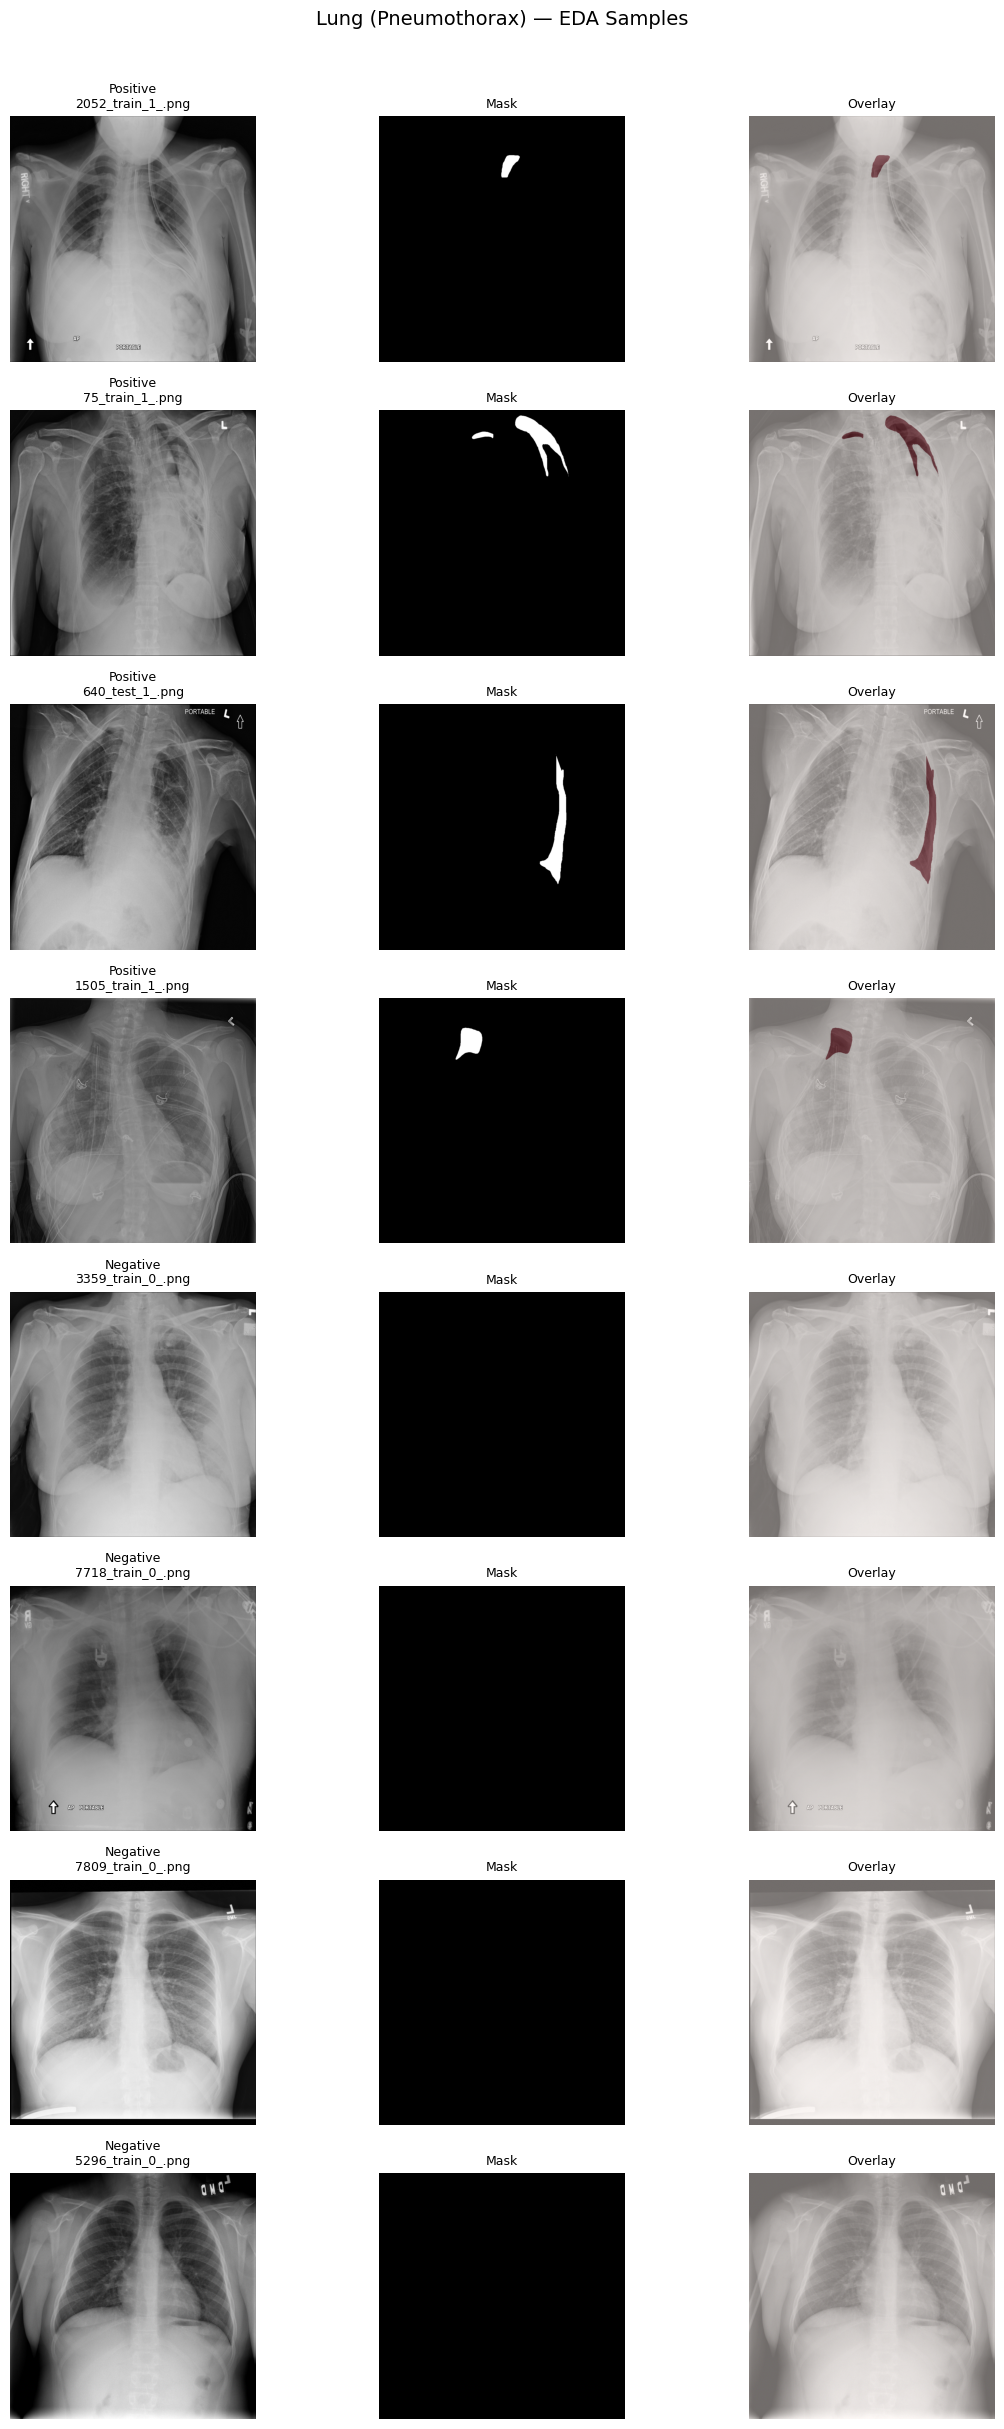

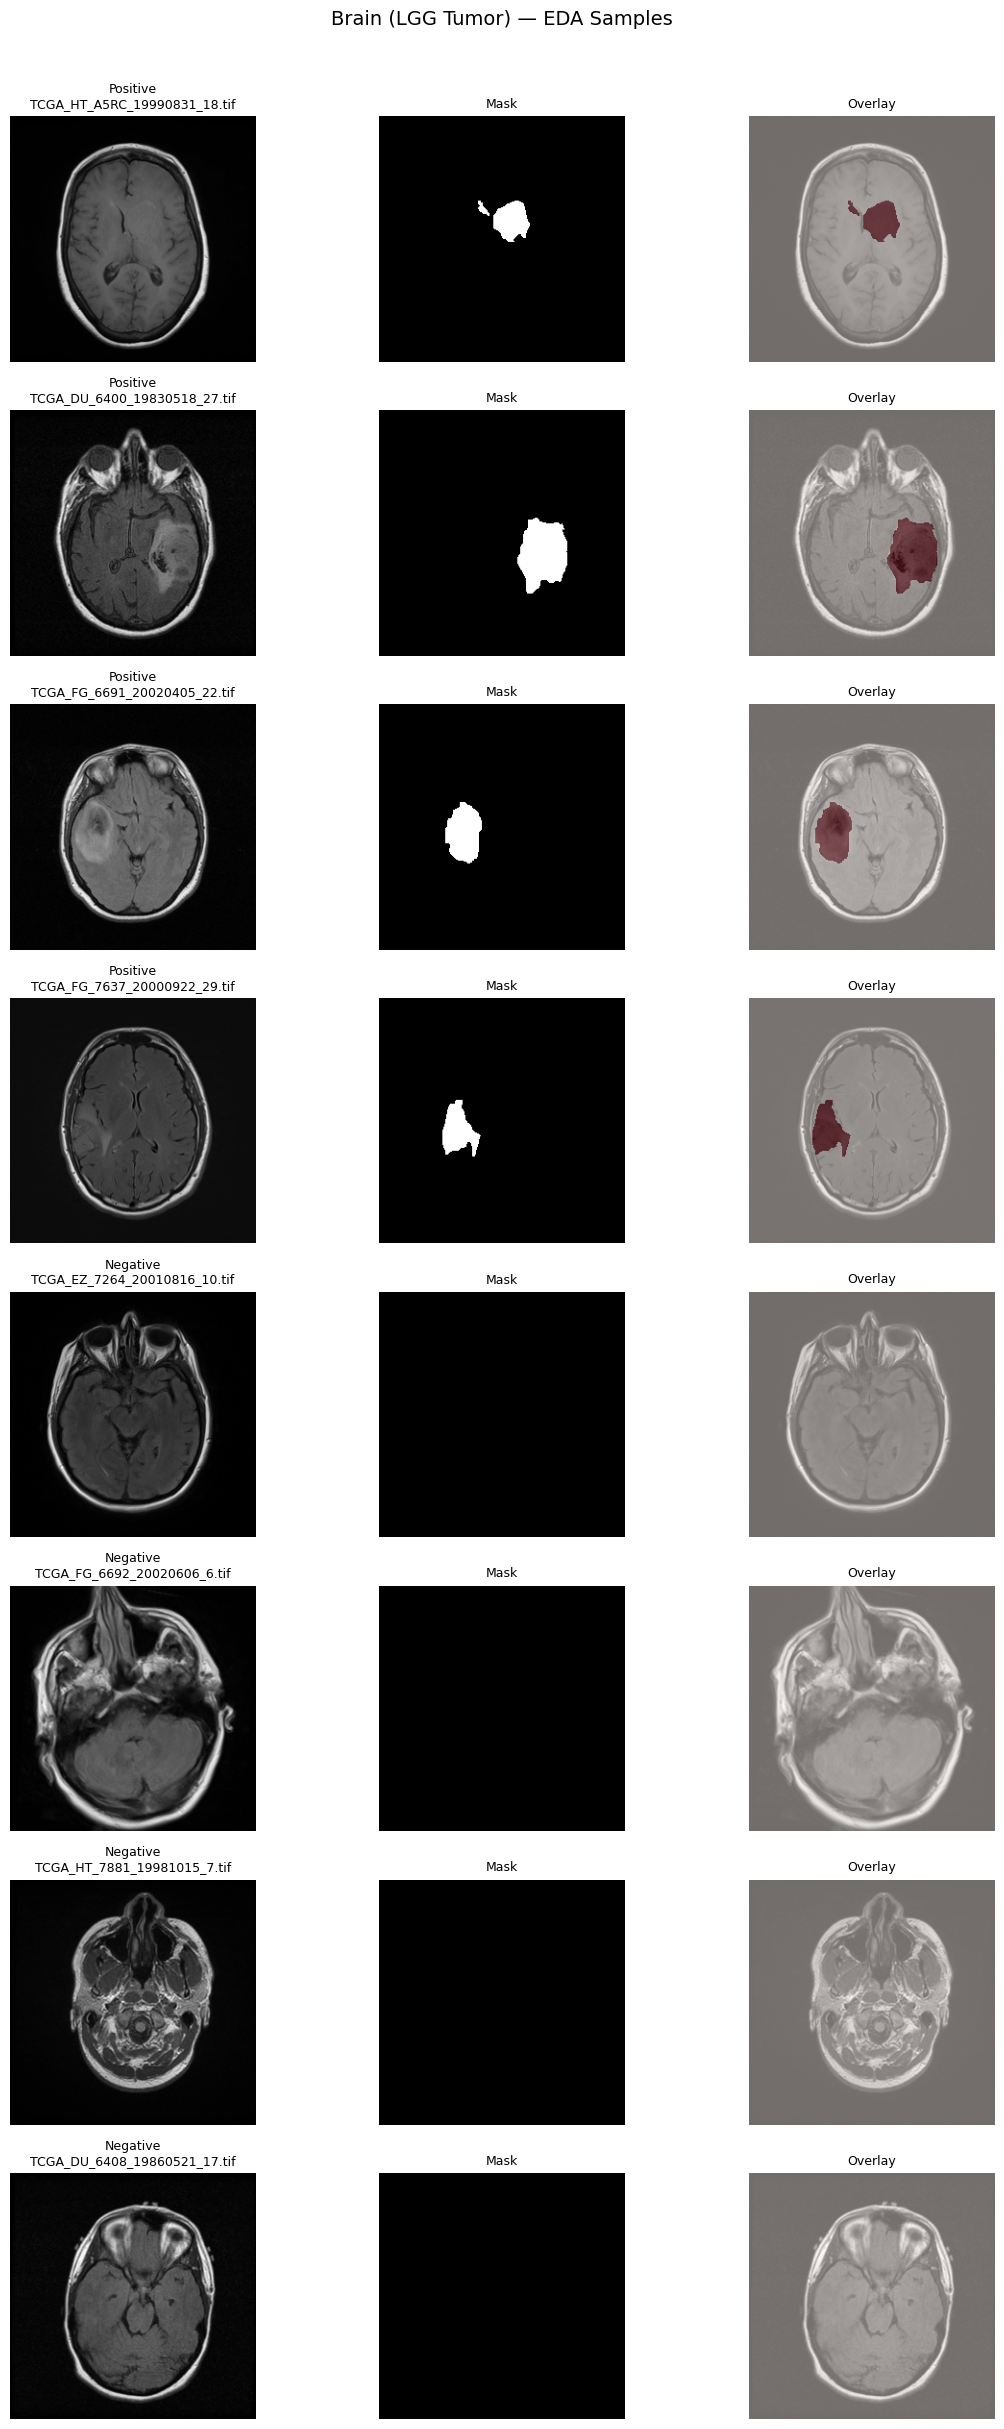

In [7]:
# ── EDA: Visualize samples from both domains ──

def get_mask_has_annotation(pairs: List[Tuple[str, str]]) -> np.ndarray:
    """Check which image-mask pairs have non-empty masks (positive class)."""
    has_annotation = np.zeros(len(pairs), dtype=int)
    for i, (_, mask_path) in enumerate(tqdm(pairs, desc="Scanning masks")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None and mask.max() > 0:
            has_annotation[i] = 1
    return has_annotation

print("Scanning lung masks for positive/negative labels...")
lung_train_has_annotation = get_mask_has_annotation(lung_train)
lung_val_has_annotation   = get_mask_has_annotation(lung_val)
lung_test_has_annotation  = get_mask_has_annotation(lung_test)

print("\nScanning brain masks for positive/negative labels...")
brain_train_has_annotation = get_mask_has_annotation(brain_train)
brain_val_has_annotation   = get_mask_has_annotation(brain_val)
brain_test_has_annotation  = get_mask_has_annotation(brain_test)

# ── Summary Table ──
print("\n" + "=" * 70)
print(" DATASET SUMMARY")
print("=" * 70)

for name, pairs, annot in [
    ("Lung  Train", lung_train, lung_train_has_annotation),
    ("Lung  Val  ", lung_val,   lung_val_has_annotation),
    ("Lung  Test ", lung_test,  lung_test_has_annotation),
    ("Brain Train", brain_train, brain_train_has_annotation),
    ("Brain Val  ", brain_val,   brain_val_has_annotation),
    ("Brain Test ", brain_test,  brain_test_has_annotation),
]:
    n = len(pairs)
    pos = annot.sum()
    neg = n - pos
    pct = 100 * pos / n if n > 0 else 0
    print(f"  {name}: {n:>6} total | {pos:>5} positive ({pct:5.1f}%) | {neg:>5} negative")

print("=" * 70)


# ── Visualize a few samples from each domain ──
def visualize_mixed_eda(pairs, has_annotation, domain_name, n_samples=4):
    """Show n positive + n negative samples from a domain."""
    pos_idx = np.where(has_annotation == 1)[0]
    neg_idx = np.where(has_annotation == 0)[0]

    np.random.seed(42)
    pos_pick = np.random.choice(pos_idx, min(n_samples, len(pos_idx)), replace=False) if len(pos_idx) > 0 else []
    neg_pick = np.random.choice(neg_idx, min(n_samples, len(neg_idx)), replace=False) if len(neg_idx) > 0 else []

    show_indices = list(pos_pick) + list(neg_pick)
    show_labels  = ["Positive"] * len(pos_pick) + ["Negative"] * len(neg_pick)

    if len(show_indices) == 0:
        print(f"No samples to show for {domain_name}")
        return

    fig, axes = plt.subplots(len(show_indices), 3, figsize=(12, len(show_indices) * 3))
    if len(show_indices) == 1:
        axes = axes.reshape(1, 3)

    for row, (idx, lbl) in enumerate(zip(show_indices, show_labels)):
        img_path, mask_path = pairs[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.zeros_like(image)

        axes[row, 0].imshow(image, cmap="gray")
        axes[row, 0].set_title(f"{lbl}\n{os.path.basename(img_path)[:30]}", fontsize=9)
        axes[row, 0].axis("off")

        axes[row, 1].imshow(mask, cmap="gray")
        axes[row, 1].set_title("Mask", fontsize=9)
        axes[row, 1].axis("off")

        axes[row, 2].imshow(image, cmap="gray")
        axes[row, 2].imshow(mask, alpha=0.45, cmap="Reds")
        axes[row, 2].set_title("Overlay", fontsize=9)
        axes[row, 2].axis("off")

    plt.suptitle(f"{domain_name} — EDA Samples", fontsize=14, y=1.01)
    plt.tight_layout()
    plt.show()

visualize_mixed_eda(lung_train, lung_train_has_annotation, "Lung (Pneumothorax)", n_samples=4)
visualize_mixed_eda(brain_train, brain_train_has_annotation, "Brain (LGG Tumor)", n_samples=4)

---
## Class Rebalancing Analysis

Pneumothorax is rare (~15-20% positive), while brain tumor masks may have a different distribution.
Since we use **batch-homogeneous** sampling (never mix organs in a batch), class rebalancing
is handled by the **WeightedRandomSampler** within each organ's training loader.

In [8]:
# ── Class Rebalancing: WeightedRandomSampler per organ ──
from torch.utils.data import WeightedRandomSampler

USE_CLASS_REBALANCING = True

def make_weighted_sampler(has_annotation: np.ndarray):
    """Create a WeightedRandomSampler that oversamples the minority class."""
    class_counts = np.bincount(has_annotation.astype(int), minlength=2)
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights[has_annotation.astype(int)]
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

if USE_CLASS_REBALANCING:
    lung_pos = lung_train_has_annotation.sum()
    lung_neg = len(lung_train_has_annotation) - lung_pos
    brain_pos = brain_train_has_annotation.sum()
    brain_neg = len(brain_train_has_annotation) - brain_pos

    print(" Class Rebalancing Enabled")
    print(f"  Lung  train: {lung_pos} positive / {lung_neg} negative  →  WeightedRandomSampler")
    print(f"  Brain train: {brain_pos} positive / {brain_neg} negative  →  WeightedRandomSampler")

    lung_train_sampler  = make_weighted_sampler(lung_train_has_annotation)
    brain_train_sampler = make_weighted_sampler(brain_train_has_annotation)
else:
    lung_train_sampler  = None
    brain_train_sampler = None
    print(" Class rebalancing disabled — using plain shuffle.")

 Class Rebalancing Enabled
  Lung  train: 1829 positive / 6603 negative  →  WeightedRandomSampler
  Brain train: 965 positive / 1785 negative  →  WeightedRandomSampler


In [9]:
train_transform = get_training_augmentation()
val_transform = get_validation_augmentation()

lung_train_ds = LungPneumoDataset(lung_train, transform=train_transform, image_size=config.IMAGE_SIZE)
lung_val_ds   = LungPneumoDataset(lung_val,   transform=val_transform,   image_size=config.IMAGE_SIZE)
lung_test_ds  = LungPneumoDataset(lung_test,  transform=val_transform,   image_size=config.IMAGE_SIZE)

brain_train_ds = BrainMRIDatasetMixed(brain_train, transform=train_transform, image_size=config.IMAGE_SIZE)
brain_val_ds   = BrainMRIDatasetMixed(brain_val,   transform=val_transform,   image_size=config.IMAGE_SIZE)
brain_test_ds  = BrainMRIDatasetMixed(brain_test,  transform=val_transform,   image_size=config.IMAGE_SIZE)

# Training loaders: use WeightedRandomSampler if class rebalancing is enabled
if USE_CLASS_REBALANCING and lung_train_sampler is not None:
    lung_train_loader = DataLoader(lung_train_ds, batch_size=config.BATCH_SIZE,
                                   sampler=lung_train_sampler,
                                   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    print(" Lung train loader: WeightedRandomSampler (class-balanced)")
else:
    lung_train_loader = DataLoader(lung_train_ds, batch_size=config.BATCH_SIZE,
                                   shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=True)
    print(" Lung train loader: shuffle=True")

if USE_CLASS_REBALANCING and brain_train_sampler is not None:
    brain_train_loader = DataLoader(brain_train_ds, batch_size=config.BATCH_SIZE,
                                    sampler=brain_train_sampler,
                                    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    print(" Brain train loader: WeightedRandomSampler (class-balanced)")
else:
    brain_train_loader = DataLoader(brain_train_ds, batch_size=config.BATCH_SIZE,
                                    shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=True)
    print(" Brain train loader: shuffle=True")

# Val / Test loaders: no sampling, no shuffle
lung_val_loader = DataLoader(lung_val_ds, batch_size=config.BATCH_SIZE,
                             shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
brain_val_loader = DataLoader(brain_val_ds, batch_size=config.BATCH_SIZE,
                              shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)

lung_test_loader = DataLoader(lung_test_ds, batch_size=config.BATCH_SIZE,
                              shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
brain_test_loader = DataLoader(brain_test_ds, batch_size=config.BATCH_SIZE,
                               shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)

print(f"\n DataLoaders created (batch-homogeneous per organ).")
print(f"  Lung  — train: {len(lung_train_loader)} batches, val: {len(lung_val_loader)}, test: {len(lung_test_loader)}")
print(f"  Brain — train: {len(brain_train_loader)} batches, val: {len(brain_val_loader)}, test: {len(brain_test_loader)}")

 Lung train loader: WeightedRandomSampler (class-balanced)
 Brain train loader: WeightedRandomSampler (class-balanced)

 DataLoaders created (batch-homogeneous per organ).
  Lung  — train: 183 batches, val: 40, test: 40
  Brain — train: 59 batches, val: 13, test: 13


In [10]:
# Sanity check: lung vs brain tensors look identical to the model

from collections import Counter
import random

def inspect_domain(ds, name, n_samples=100):
    shapes = Counter()
    dtypes = Counter()
    mask_shapes = Counter()
    mask_dtypes = Counter()
    img_mins, img_maxs = [], []
    mask_mins, mask_maxs = [], []
    
    n = min(n_samples, len(ds))
    idxs = random.sample(range(len(ds)), n)
    
    for i in idxs:
        img, mask = ds[i]  # tensors after all preprocessing
        shapes[tuple(img.shape)] += 1
        dtypes[str(img.dtype)] += 1
        mask_shapes[tuple(mask.shape)] += 1
        mask_dtypes[str(mask.dtype)] += 1
        img_mins.append(float(img.min()))
        img_maxs.append(float(img.max()))
        mask_mins.append(float(mask.min()))
        mask_maxs.append(float(mask.max()))
    
    print(f"\n=== {name} ===")
    print("Image shapes:", dict(shapes))
    print("Image dtypes:", dict(dtypes))
    print("Mask shapes:", dict(mask_shapes))
    print("Mask dtypes:", dict(mask_dtypes))
    print(f"Image value range over {n} samples: "
          f"[{min(img_mins):.3f}, {max(img_maxs):.3f}]")
    print(f"Mask value range over {n} samples: "
          f"[{min(mask_mins):.3f}, {max(mask_maxs):.3f}]")

print("Checking train sets (post‑augmentation tensors):")
inspect_domain(lung_train_ds,  "Lung train")
inspect_domain(brain_train_ds, "Brain train")

print("\nChecking val sets:")
inspect_domain(lung_val_ds,  "Lung val")
inspect_domain(brain_val_ds, "Brain val")

# check raw file‑level differences

print("Example raw paths:")
print("Lung:", lung_train[0][0])
print("Brain:", brain_train[0][0])

lung_exts = {os.path.splitext(p)[1].lower() for p, _ in lung_train}
brain_exts = {os.path.splitext(p)[1].lower() for p, _ in brain_train}
print("Lung extensions:", lung_exts)
print("Brain extensions:", brain_exts)

Checking train sets (post‑augmentation tensors):

=== Lung train ===
Image shapes: {(3, 256, 256): 100}
Image dtypes: {'torch.float32': 100}
Mask shapes: {(1, 256, 256): 100}
Mask dtypes: {'torch.float32': 100}
Image value range over 100 samples: [-4.256, 4.099]
Mask value range over 100 samples: [0.000, 1.000]

=== Lung train ===
Image shapes: {(3, 256, 256): 100}
Image dtypes: {'torch.float32': 100}
Mask shapes: {(1, 256, 256): 100}
Mask dtypes: {'torch.float32': 100}
Image value range over 100 samples: [-4.256, 4.099]
Mask value range over 100 samples: [0.000, 1.000]

=== Brain train ===
Image shapes: {(3, 256, 256): 100}
Image dtypes: {'torch.float32': 100}
Mask shapes: {(1, 256, 256): 100}
Mask dtypes: {'torch.float32': 100}
Image value range over 100 samples: [-2.945, 10.002]
Mask value range over 100 samples: [0.000, 1.000]

Checking val sets:

=== Brain train ===
Image shapes: {(3, 256, 256): 100}
Image dtypes: {'torch.float32': 100}
Mask shapes: {(1, 256, 256): 100}
Mask dtype

**Thus, no structural cue (difference in shape/channels/dtype) is given.**
- No mask formatting cue is different.
- Preprocessing code is the same (per‑image z‑score → 3‑channel) for both domains.
- The only differences are in the actual pixel distributions, which is exactly the information you want the model to use.

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name=config.ENCODER,
    encoder_weights=config.ENCODER_WEIGHTS,
    in_channels=config.IN_CHANNELS,
    classes=1,
    activation=None,
    decoder_attention_type=None,      # explicitly no attention
    decoder_dropout=0.1
)
model = model.to(config.DEVICE)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    # verbose=True
)

scaler = GradScaler(enabled=config.MIXED_PRECISION)

print(" Mixed UNet++ model initialized.")

 Mixed UNet++ model initialized.


In [11]:
from itertools import cycle

def train_one_epoch_mixed(epoch: int):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_f1 = 0.0
    total_samples = 0
    
    # Clear GPU cache at start of epoch to prevent fragmentation
    torch.cuda.empty_cache()
    
    lung_iter = iter(lung_train_loader)
    brain_iter = cycle(brain_train_loader)   # cycle the shorter loader
    num_steps = len(lung_train_loader)        # epoch = full pass over larger dataset
    
    pbar = tqdm(range(num_steps), desc=f"Epoch {epoch+1} [train mixed]")
    
    for _ in pbar:
        # Enforce batch-homogeneous + 50/50 sampling by doing one lung then one brain batch
        for domain, loader_iter in [("lung", lung_iter), ("brain", brain_iter)]:
            try:
                images, masks = next(loader_iter)
            except StopIteration:
                continue
            
            images = images.to(config.DEVICE)
            masks = masks.to(config.DEVICE)
            batch_size = images.size(0)
            total_samples += batch_size
            
            optimizer.zero_grad()
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            scaler.scale(loss).backward()
            # Gradient clipping for stability (especially with class rebalancing)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            with torch.no_grad():
                batch_dice = dice_coefficient(outputs, masks).item()
                batch_f1 = f1_score(outputs, masks).item()
            
            running_loss += loss.item() * batch_size
            running_dice += batch_dice * batch_size
            running_f1 += batch_f1 * batch_size
            
            pbar.set_postfix({
                "loss": running_loss / max(total_samples, 1),
                "dice": running_dice / max(total_samples, 1),
            })
    
    if total_samples == 0:
        return 0.0, 0.0, 0.0
    
    epoch_loss = running_loss / total_samples
    epoch_dice = running_dice / total_samples
    epoch_f1 = running_f1 / total_samples
    
    return epoch_loss, epoch_dice, epoch_f1

In [ ]:
@torch.no_grad()
def evaluate_mixed(device, threshold: float = 0.5):
    model.eval()
    metrics = {
        "loss": 0.0,
        "dice": 0.0,
        "iou": 0.0,
        "f1": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "accuracy": 0.0,
    }
    total_samples = 0
    
    def eval_loader(loader, name: str):
        nonlocal metrics, total_samples
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            batch_size = images.size(0)
            total_samples += batch_size
            
            with autocast(enabled=config.MIXED_PRECISION):
                logits = model(images)
                loss = criterion(logits, masks)
            
            metrics["loss"] += loss.item() * batch_size
            
            # For Dice, use canonical per-sample definition
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            dice_batch = dice_per_sample(preds, masks)  # [B]
            metrics["dice"] += dice_batch.sum().item()
            
            # Other metrics
            iou_b = iou_score(logits, masks, threshold=threshold).item()
            f1_b = f1_score(logits, masks, threshold=threshold).item()
            prec_b = precision_score(logits, masks, threshold=threshold).item()
            rec_b = recall_score(logits, masks, threshold=threshold).item()
            acc_b = accuracy_score(logits, masks, threshold=threshold).item()
            
            metrics["iou"] += iou_b * batch_size
            metrics["f1"] += f1_b * batch_size
            metrics["precision"] += prec_b * batch_size
            metrics["recall"] += rec_b * batch_size
            metrics["accuracy"] += acc_b * batch_size
    
    print("\n=== Validation on Lung + Brain (no TTA) ===")
    if len(lung_val_loader) > 0:
        print(" Evaluating lung validation...")
        eval_loader(lung_val_loader, "lung")
    if len(brain_val_loader) > 0:
        print(" Evaluating brain validation...")
        eval_loader(brain_val_loader, "brain")
    
    if total_samples == 0:
        print("No validation samples.")
        return metrics
    
    for k in metrics:
        metrics[k] /= total_samples
    
    print(f" Loss: {metrics['loss']:.4f}")
    print(f" Dice: {metrics['dice']:.4f}")
    print(f" IoU:  {metrics['iou']:.4f}")
    print(f" F1:   {metrics['f1']:.4f}")
    print(f" Prec: {metrics['precision']:.4f}")
    print(f" Rec:  {metrics['recall']:.4f}")
    print(f" Acc:  {metrics['accuracy']:.4f}")
    
    return metrics

In [13]:
best_val_dice = 0.0
best_model_path = None
patience_counter = 0

history = {
    "train_loss": [],
    "train_dice": [],
    "train_f1": [],
    "val_loss": [],
    "val_dice": [],
    "val_iou": [],
    "val_f1": [],
}

print("=" * 60)
print(" STARTING MIXED LUNG + BRAIN TRAINING")
print("=" * 60)

for epoch in range(config.EPOCHS):
    train_loss, train_dice, train_f1 = train_one_epoch_mixed(epoch)
    
    val_metrics = evaluate_mixed(config.DEVICE, threshold=0.5)
    
    val_loss = val_metrics["loss"]
    val_dice = val_metrics["dice"]
    val_iou  = val_metrics["iou"]
    val_f1   = val_metrics["f1"]
    
    scheduler.step(val_dice)
    
    history["train_loss"].append(train_loss)
    history["train_dice"].append(train_dice)
    history["train_f1"].append(train_f1)
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_dice)
    history["val_iou"].append(val_iou)
    history["val_f1"].append(val_f1)
    
    print(f"\nEpoch {epoch+1}:")
    print(f"  Train  - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, F1: {train_f1:.4f}")
    print(f"  Val    - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, F1: {val_f1:.4f}")
    
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        patience_counter = 0
        model_name = f"mixed_dice{val_dice:.4f}_iou{val_iou:.4f}.pth"
        best_model_path = os.path.join(config.OUTPUT_DIR, model_name)
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "val_dice": val_dice,
            "val_iou": val_iou,
            "encoder": config.ENCODER,
            "image_size": config.IMAGE_SIZE,
            "in_channels": config.IN_CHANNELS,
            "history": history,
        }, best_model_path)
        print(f"  \u2705 New best model saved: {model_name}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{config.PATIENCE})")
        if patience_counter >= config.PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("\n" + "=" * 60)
print(f" MIXED TRAINING COMPLETE! Best Val Dice: {best_val_dice:.4f}")
print("=" * 60)

 STARTING MIXED LUNG + BRAIN TRAINING


Epoch 1 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 1.0844
 Dice: 0.6785
 IoU:  0.6633
 F1:   0.6785
 Prec: 0.8241
 Rec:  0.7915
 Acc:  0.9957

Epoch 1:
  Train  - Loss: 1.3201, Dice: 0.2428, F1: 0.2428
  Val    - Loss: 1.0844, Dice: 0.6785, IoU: 0.6633, F1: 0.6785
  ✅ New best model saved: mixed_dice0.6785_iou0.6633.pth
 Loss: 1.0844
 Dice: 0.6785
 IoU:  0.6633
 F1:   0.6785
 Prec: 0.8241
 Rec:  0.7915
 Acc:  0.9957

Epoch 1:
  Train  - Loss: 1.3201, Dice: 0.2428, F1: 0.2428
  Val    - Loss: 1.0844, Dice: 0.6785, IoU: 0.6633, F1: 0.6785
  ✅ New best model saved: mixed_dice0.6785_iou0.6633.pth


Epoch 2 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.8777
 Dice: 0.7502
 IoU:  0.7348
 F1:   0.7502
 Prec: 0.9123
 Rec:  0.7943
 Acc:  0.9962

Epoch 2:
  Train  - Loss: 0.8363, Dice: 0.5571, F1: 0.5571
  Val    - Loss: 0.8777, Dice: 0.7502, IoU: 0.7348, F1: 0.7502
  ✅ New best model saved: mixed_dice0.7502_iou0.7348.pth
 Loss: 0.8777
 Dice: 0.7502
 IoU:  0.7348
 F1:   0.7502
 Prec: 0.9123
 Rec:  0.7943
 Acc:  0.9962

Epoch 2:
  Train  - Loss: 0.8363, Dice: 0.5571, F1: 0.5571
  Val    - Loss: 0.8777, Dice: 0.7502, IoU: 0.7348, F1: 0.7502
  ✅ New best model saved: mixed_dice0.7502_iou0.7348.pth


Epoch 3 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.7161
 Dice: 0.7267
 IoU:  0.7112
 F1:   0.7267
 Prec: 0.8689
 Rec:  0.8077
 Acc:  0.9962

Epoch 3:
  Train  - Loss: 0.5348, Dice: 0.6496, F1: 0.6496
  Val    - Loss: 0.7161, Dice: 0.7267, IoU: 0.7112, F1: 0.7267
  No improvement (1/15)
 Loss: 0.7161
 Dice: 0.7267
 IoU:  0.7112
 F1:   0.7267
 Prec: 0.8689
 Rec:  0.8077
 Acc:  0.9962

Epoch 3:
  Train  - Loss: 0.5348, Dice: 0.6496, F1: 0.6496
  Val    - Loss: 0.7161, Dice: 0.7267, IoU: 0.7112, F1: 0.7267
  No improvement (1/15)


Epoch 4 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.7235
 Dice: 0.7366
 IoU:  0.7227
 F1:   0.7366
 Prec: 0.8981
 Rec:  0.7948
 Acc:  0.9963

Epoch 4:
  Train  - Loss: 0.4112, Dice: 0.6876, F1: 0.6876
  Val    - Loss: 0.7235, Dice: 0.7366, IoU: 0.7227, F1: 0.7366
  No improvement (2/15)
 Loss: 0.7235
 Dice: 0.7366
 IoU:  0.7227
 F1:   0.7366
 Prec: 0.8981
 Rec:  0.7948
 Acc:  0.9963

Epoch 4:
  Train  - Loss: 0.4112, Dice: 0.6876, F1: 0.6876
  Val    - Loss: 0.7235, Dice: 0.7366, IoU: 0.7227, F1: 0.7366
  No improvement (2/15)


Epoch 5 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6468
 Dice: 0.7629
 IoU:  0.7465
 F1:   0.7629
 Prec: 0.9155
 Rec:  0.8027
 Acc:  0.9965

Epoch 5:
  Train  - Loss: 0.3732, Dice: 0.6986, F1: 0.6986
  Val    - Loss: 0.6468, Dice: 0.7629, IoU: 0.7465, F1: 0.7629
 Loss: 0.6468
 Dice: 0.7629
 IoU:  0.7465
 F1:   0.7629
 Prec: 0.9155
 Rec:  0.8027
 Acc:  0.9965

Epoch 5:
  Train  - Loss: 0.3732, Dice: 0.6986, F1: 0.6986
  Val    - Loss: 0.6468, Dice: 0.7629, IoU: 0.7465, F1: 0.7629
  ✅ New best model saved: mixed_dice0.7629_iou0.7465.pth
  ✅ New best model saved: mixed_dice0.7629_iou0.7465.pth


Epoch 6 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5901
 Dice: 0.7722
 IoU:  0.7531
 F1:   0.7722
 Prec: 0.9063
 Rec:  0.8158
 Acc:  0.9965

Epoch 6:
  Train  - Loss: 0.3506, Dice: 0.7100, F1: 0.7100
  Val    - Loss: 0.5901, Dice: 0.7722, IoU: 0.7531, F1: 0.7722
  ✅ New best model saved: mixed_dice0.7722_iou0.7531.pth
 Loss: 0.5901
 Dice: 0.7722
 IoU:  0.7531
 F1:   0.7722
 Prec: 0.9063
 Rec:  0.8158
 Acc:  0.9965

Epoch 6:
  Train  - Loss: 0.3506, Dice: 0.7100, F1: 0.7100
  Val    - Loss: 0.5901, Dice: 0.7722, IoU: 0.7531, F1: 0.7722
  ✅ New best model saved: mixed_dice0.7722_iou0.7531.pth


Epoch 7 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5614
 Dice: 0.7765
 IoU:  0.7559
 F1:   0.7765
 Prec: 0.9023
 Rec:  0.8233
 Acc:  0.9966

Epoch 7:
  Train  - Loss: 0.3291, Dice: 0.7265, F1: 0.7265
  Val    - Loss: 0.5614, Dice: 0.7765, IoU: 0.7559, F1: 0.7765
  ✅ New best model saved: mixed_dice0.7765_iou0.7559.pth
 Loss: 0.5614
 Dice: 0.7765
 IoU:  0.7559
 F1:   0.7765
 Prec: 0.9023
 Rec:  0.8233
 Acc:  0.9966

Epoch 7:
  Train  - Loss: 0.3291, Dice: 0.7265, F1: 0.7265
  Val    - Loss: 0.5614, Dice: 0.7765, IoU: 0.7559, F1: 0.7765
  ✅ New best model saved: mixed_dice0.7765_iou0.7559.pth


Epoch 8 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6204
 Dice: 0.7883
 IoU:  0.7705
 F1:   0.7883
 Prec: 0.9458
 Rec:  0.8037
 Acc:  0.9965

Epoch 8:
  Train  - Loss: 0.3214, Dice: 0.7316, F1: 0.7316
  Val    - Loss: 0.6204, Dice: 0.7883, IoU: 0.7705, F1: 0.7883
  ✅ New best model saved: mixed_dice0.7883_iou0.7705.pth
 Loss: 0.6204
 Dice: 0.7883
 IoU:  0.7705
 F1:   0.7883
 Prec: 0.9458
 Rec:  0.8037
 Acc:  0.9965

Epoch 8:
  Train  - Loss: 0.3214, Dice: 0.7316, F1: 0.7316
  Val    - Loss: 0.6204, Dice: 0.7883, IoU: 0.7705, F1: 0.7883
  ✅ New best model saved: mixed_dice0.7883_iou0.7705.pth


Epoch 9 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5440
 Dice: 0.7831
 IoU:  0.7614
 F1:   0.7831
 Prec: 0.9018
 Rec:  0.8281
 Acc:  0.9966

Epoch 9:
  Train  - Loss: 0.3119, Dice: 0.7404, F1: 0.7404
  Val    - Loss: 0.5440, Dice: 0.7831, IoU: 0.7614, F1: 0.7831
  No improvement (1/15)
 Loss: 0.5440
 Dice: 0.7831
 IoU:  0.7614
 F1:   0.7831
 Prec: 0.9018
 Rec:  0.8281
 Acc:  0.9966

Epoch 9:
  Train  - Loss: 0.3119, Dice: 0.7404, F1: 0.7404
  Val    - Loss: 0.5440, Dice: 0.7831, IoU: 0.7614, F1: 0.7831
  No improvement (1/15)


Epoch 10 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5913
 Dice: 0.7826
 IoU:  0.7621
 F1:   0.7826
 Prec: 0.9192
 Rec:  0.8155
 Acc:  0.9964

Epoch 10:
  Train  - Loss: 0.2941, Dice: 0.7486, F1: 0.7486
  Val    - Loss: 0.5913, Dice: 0.7826, IoU: 0.7621, F1: 0.7826
  No improvement (2/15)
 Loss: 0.5913
 Dice: 0.7826
 IoU:  0.7621
 F1:   0.7826
 Prec: 0.9192
 Rec:  0.8155
 Acc:  0.9964

Epoch 10:
  Train  - Loss: 0.2941, Dice: 0.7486, F1: 0.7486
  Val    - Loss: 0.5913, Dice: 0.7826, IoU: 0.7621, F1: 0.7826
  No improvement (2/15)


Epoch 11 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5622
 Dice: 0.7841
 IoU:  0.7626
 F1:   0.7841
 Prec: 0.9028
 Rec:  0.8293
 Acc:  0.9965

Epoch 11:
  Train  - Loss: 0.2913, Dice: 0.7541, F1: 0.7541
  Val    - Loss: 0.5622, Dice: 0.7841, IoU: 0.7626, F1: 0.7841
  No improvement (3/15)
 Loss: 0.5622
 Dice: 0.7841
 IoU:  0.7626
 F1:   0.7841
 Prec: 0.9028
 Rec:  0.8293
 Acc:  0.9965

Epoch 11:
  Train  - Loss: 0.2913, Dice: 0.7541, F1: 0.7541
  Val    - Loss: 0.5622, Dice: 0.7841, IoU: 0.7626, F1: 0.7841
  No improvement (3/15)


Epoch 12 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5670
 Dice: 0.7961
 IoU:  0.7766
 F1:   0.7961
 Prec: 0.9366
 Rec:  0.8160
 Acc:  0.9965

Epoch 12:
  Train  - Loss: 0.2821, Dice: 0.7592, F1: 0.7592
  Val    - Loss: 0.5670, Dice: 0.7961, IoU: 0.7766, F1: 0.7961
  ✅ New best model saved: mixed_dice0.7961_iou0.7766.pth
 Loss: 0.5670
 Dice: 0.7961
 IoU:  0.7766
 F1:   0.7961
 Prec: 0.9366
 Rec:  0.8160
 Acc:  0.9965

Epoch 12:
  Train  - Loss: 0.2821, Dice: 0.7592, F1: 0.7592
  Val    - Loss: 0.5670, Dice: 0.7961, IoU: 0.7766, F1: 0.7961
  ✅ New best model saved: mixed_dice0.7961_iou0.7766.pth


Epoch 13 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5515
 Dice: 0.7873
 IoU:  0.7666
 F1:   0.7873
 Prec: 0.9104
 Rec:  0.8253
 Acc:  0.9966

Epoch 13:
  Train  - Loss: 0.2798, Dice: 0.7595, F1: 0.7595
  Val    - Loss: 0.5515, Dice: 0.7873, IoU: 0.7666, F1: 0.7873
  No improvement (1/15)
 Loss: 0.5515
 Dice: 0.7873
 IoU:  0.7666
 F1:   0.7873
 Prec: 0.9104
 Rec:  0.8253
 Acc:  0.9966

Epoch 13:
  Train  - Loss: 0.2798, Dice: 0.7595, F1: 0.7595
  Val    - Loss: 0.5515, Dice: 0.7873, IoU: 0.7666, F1: 0.7873
  No improvement (1/15)


Epoch 14 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5641
 Dice: 0.7787
 IoU:  0.7577
 F1:   0.7787
 Prec: 0.8960
 Rec:  0.8303
 Acc:  0.9966

Epoch 14:
  Train  - Loss: 0.2689, Dice: 0.7643, F1: 0.7643
  Val    - Loss: 0.5641, Dice: 0.7787, IoU: 0.7577, F1: 0.7787
  No improvement (2/15)
 Loss: 0.5641
 Dice: 0.7787
 IoU:  0.7577
 F1:   0.7787
 Prec: 0.8960
 Rec:  0.8303
 Acc:  0.9966

Epoch 14:
  Train  - Loss: 0.2689, Dice: 0.7643, F1: 0.7643
  Val    - Loss: 0.5641, Dice: 0.7787, IoU: 0.7577, F1: 0.7787
  No improvement (2/15)


Epoch 15 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6369
 Dice: 0.7900
 IoU:  0.7744
 F1:   0.7900
 Prec: 0.9477
 Rec:  0.8080
 Acc:  0.9966

Epoch 15:
  Train  - Loss: 0.2683, Dice: 0.7670, F1: 0.7670
  Val    - Loss: 0.6369, Dice: 0.7900, IoU: 0.7744, F1: 0.7900
  No improvement (3/15)
 Loss: 0.6369
 Dice: 0.7900
 IoU:  0.7744
 F1:   0.7900
 Prec: 0.9477
 Rec:  0.8080
 Acc:  0.9966

Epoch 15:
  Train  - Loss: 0.2683, Dice: 0.7670, F1: 0.7670
  Val    - Loss: 0.6369, Dice: 0.7900, IoU: 0.7744, F1: 0.7900
  No improvement (3/15)


Epoch 16 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5567
 Dice: 0.7695
 IoU:  0.7464
 F1:   0.7695
 Prec: 0.8715
 Rec:  0.8386
 Acc:  0.9965

Epoch 16:
  Train  - Loss: 0.2627, Dice: 0.7754, F1: 0.7754
  Val    - Loss: 0.5567, Dice: 0.7695, IoU: 0.7464, F1: 0.7695
  No improvement (4/15)
 Loss: 0.5567
 Dice: 0.7695
 IoU:  0.7464
 F1:   0.7695
 Prec: 0.8715
 Rec:  0.8386
 Acc:  0.9965

Epoch 16:
  Train  - Loss: 0.2627, Dice: 0.7754, F1: 0.7754
  Val    - Loss: 0.5567, Dice: 0.7695, IoU: 0.7464, F1: 0.7695
  No improvement (4/15)


Epoch 17 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6069
 Dice: 0.7942
 IoU:  0.7766
 F1:   0.7942
 Prec: 0.9374
 Rec:  0.8158
 Acc:  0.9966

Epoch 17:
  Train  - Loss: 0.2534, Dice: 0.7749, F1: 0.7749
  Val    - Loss: 0.6069, Dice: 0.7942, IoU: 0.7766, F1: 0.7942
  No improvement (5/15)
 Loss: 0.6069
 Dice: 0.7942
 IoU:  0.7766
 F1:   0.7942
 Prec: 0.9374
 Rec:  0.8158
 Acc:  0.9966

Epoch 17:
  Train  - Loss: 0.2534, Dice: 0.7749, F1: 0.7749
  Val    - Loss: 0.6069, Dice: 0.7942, IoU: 0.7766, F1: 0.7942
  No improvement (5/15)


Epoch 18 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6056
 Dice: 0.7445
 IoU:  0.7227
 F1:   0.7445
 Prec: 0.8561
 Rec:  0.8272
 Acc:  0.9965

Epoch 18:
  Train  - Loss: 0.2466, Dice: 0.7800, F1: 0.7800
  Val    - Loss: 0.6056, Dice: 0.7445, IoU: 0.7227, F1: 0.7445
  No improvement (6/15)
 Loss: 0.6056
 Dice: 0.7445
 IoU:  0.7227
 F1:   0.7445
 Prec: 0.8561
 Rec:  0.8272
 Acc:  0.9965

Epoch 18:
  Train  - Loss: 0.2466, Dice: 0.7800, F1: 0.7800
  Val    - Loss: 0.6056, Dice: 0.7445, IoU: 0.7227, F1: 0.7445
  No improvement (6/15)


Epoch 19 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6175
 Dice: 0.7843
 IoU:  0.7651
 F1:   0.7843
 Prec: 0.9264
 Rec:  0.8156
 Acc:  0.9965

Epoch 19:
  Train  - Loss: 0.2389, Dice: 0.7907, F1: 0.7907
  Val    - Loss: 0.6175, Dice: 0.7843, IoU: 0.7651, F1: 0.7843
  No improvement (7/15)
 Loss: 0.6175
 Dice: 0.7843
 IoU:  0.7651
 F1:   0.7843
 Prec: 0.9264
 Rec:  0.8156
 Acc:  0.9965

Epoch 19:
  Train  - Loss: 0.2389, Dice: 0.7907, F1: 0.7907
  Val    - Loss: 0.6175, Dice: 0.7843, IoU: 0.7651, F1: 0.7843
  No improvement (7/15)


Epoch 20 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5728
 Dice: 0.7795
 IoU:  0.7578
 F1:   0.7795
 Prec: 0.9006
 Rec:  0.8284
 Acc:  0.9965

Epoch 20:
  Train  - Loss: 0.2264, Dice: 0.7996, F1: 0.7996
  Val    - Loss: 0.5728, Dice: 0.7795, IoU: 0.7578, F1: 0.7795
  No improvement (8/15)
 Loss: 0.5728
 Dice: 0.7795
 IoU:  0.7578
 F1:   0.7795
 Prec: 0.9006
 Rec:  0.8284
 Acc:  0.9965

Epoch 20:
  Train  - Loss: 0.2264, Dice: 0.7996, F1: 0.7996
  Val    - Loss: 0.5728, Dice: 0.7795, IoU: 0.7578, F1: 0.7795
  No improvement (8/15)


Epoch 21 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5674
 Dice: 0.7766
 IoU:  0.7544
 F1:   0.7766
 Prec: 0.8878
 Rec:  0.8348
 Acc:  0.9965

Epoch 21:
  Train  - Loss: 0.2292, Dice: 0.8003, F1: 0.8003
  Val    - Loss: 0.5674, Dice: 0.7766, IoU: 0.7544, F1: 0.7766
  No improvement (9/15)
 Loss: 0.5674
 Dice: 0.7766
 IoU:  0.7544
 F1:   0.7766
 Prec: 0.8878
 Rec:  0.8348
 Acc:  0.9965

Epoch 21:
  Train  - Loss: 0.2292, Dice: 0.8003, F1: 0.8003
  Val    - Loss: 0.5674, Dice: 0.7766, IoU: 0.7544, F1: 0.7766
  No improvement (9/15)


Epoch 22 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6281
 Dice: 0.7899
 IoU:  0.7713
 F1:   0.7899
 Prec: 0.9304
 Rec:  0.8166
 Acc:  0.9966

Epoch 22:
  Train  - Loss: 0.2235, Dice: 0.8000, F1: 0.8000
  Val    - Loss: 0.6281, Dice: 0.7899, IoU: 0.7713, F1: 0.7899
  No improvement (10/15)
 Loss: 0.6281
 Dice: 0.7899
 IoU:  0.7713
 F1:   0.7899
 Prec: 0.9304
 Rec:  0.8166
 Acc:  0.9966

Epoch 22:
  Train  - Loss: 0.2235, Dice: 0.8000, F1: 0.8000
  Val    - Loss: 0.6281, Dice: 0.7899, IoU: 0.7713, F1: 0.7899
  No improvement (10/15)


Epoch 23 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6089
 Dice: 0.7820
 IoU:  0.7613
 F1:   0.7820
 Prec: 0.9134
 Rec:  0.8182
 Acc:  0.9965

Epoch 23:
  Train  - Loss: 0.2173, Dice: 0.8002, F1: 0.8002
  Val    - Loss: 0.6089, Dice: 0.7820, IoU: 0.7613, F1: 0.7820
  No improvement (11/15)
 Loss: 0.6089
 Dice: 0.7820
 IoU:  0.7613
 F1:   0.7820
 Prec: 0.9134
 Rec:  0.8182
 Acc:  0.9965

Epoch 23:
  Train  - Loss: 0.2173, Dice: 0.8002, F1: 0.8002
  Val    - Loss: 0.6089, Dice: 0.7820, IoU: 0.7613, F1: 0.7820
  No improvement (11/15)


Epoch 24 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5943
 Dice: 0.7812
 IoU:  0.7598
 F1:   0.7812
 Prec: 0.9018
 Rec:  0.8257
 Acc:  0.9965

Epoch 24:
  Train  - Loss: 0.2227, Dice: 0.7982, F1: 0.7982
  Val    - Loss: 0.5943, Dice: 0.7812, IoU: 0.7598, F1: 0.7812
  No improvement (12/15)
 Loss: 0.5943
 Dice: 0.7812
 IoU:  0.7598
 F1:   0.7812
 Prec: 0.9018
 Rec:  0.8257
 Acc:  0.9965

Epoch 24:
  Train  - Loss: 0.2227, Dice: 0.7982, F1: 0.7982
  Val    - Loss: 0.5943, Dice: 0.7812, IoU: 0.7598, F1: 0.7812
  No improvement (12/15)


Epoch 25 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5997
 Dice: 0.7827
 IoU:  0.7622
 F1:   0.7827
 Prec: 0.9099
 Rec:  0.8237
 Acc:  0.9965

Epoch 25:
  Train  - Loss: 0.2133, Dice: 0.8078, F1: 0.8078
  Val    - Loss: 0.5997, Dice: 0.7827, IoU: 0.7622, F1: 0.7827
  No improvement (13/15)
 Loss: 0.5997
 Dice: 0.7827
 IoU:  0.7622
 F1:   0.7827
 Prec: 0.9099
 Rec:  0.8237
 Acc:  0.9965

Epoch 25:
  Train  - Loss: 0.2133, Dice: 0.8078, F1: 0.8078
  Val    - Loss: 0.5997, Dice: 0.7827, IoU: 0.7622, F1: 0.7827
  No improvement (13/15)


Epoch 26 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.6124
 Dice: 0.7897
 IoU:  0.7706
 F1:   0.7897
 Prec: 0.9217
 Rec:  0.8210
 Acc:  0.9966

Epoch 26:
  Train  - Loss: 0.2111, Dice: 0.8082, F1: 0.8082
  Val    - Loss: 0.6124, Dice: 0.7897, IoU: 0.7706, F1: 0.7897
  No improvement (14/15)
 Loss: 0.6124
 Dice: 0.7897
 IoU:  0.7706
 F1:   0.7897
 Prec: 0.9217
 Rec:  0.8210
 Acc:  0.9966

Epoch 26:
  Train  - Loss: 0.2111, Dice: 0.8082, F1: 0.8082
  Val    - Loss: 0.6124, Dice: 0.7897, IoU: 0.7706, F1: 0.7897
  No improvement (14/15)


Epoch 27 [train mixed]:   0%|          | 0/183 [00:00<?, ?it/s]


=== Validation on Lung + Brain (no TTA) ===
 Evaluating lung validation...
 Evaluating brain validation...
 Evaluating brain validation...
 Loss: 0.5953
 Dice: 0.7759
 IoU:  0.7549
 F1:   0.7759
 Prec: 0.8985
 Rec:  0.8263
 Acc:  0.9965

Epoch 27:
  Train  - Loss: 0.2074, Dice: 0.8110, F1: 0.8110
  Val    - Loss: 0.5953, Dice: 0.7759, IoU: 0.7549, F1: 0.7759
  No improvement (15/15)

Early stopping at epoch 27

 MIXED TRAINING COMPLETE! Best Val Dice: 0.7961
 Loss: 0.5953
 Dice: 0.7759
 IoU:  0.7549
 F1:   0.7759
 Prec: 0.8985
 Rec:  0.8263
 Acc:  0.9965

Epoch 27:
  Train  - Loss: 0.2074, Dice: 0.8110, F1: 0.8110
  Val    - Loss: 0.5953, Dice: 0.7759, IoU: 0.7549, F1: 0.7759
  No improvement (15/15)

Early stopping at epoch 27

 MIXED TRAINING COMPLETE! Best Val Dice: 0.7961


---
## Training Curves

Visualize loss, Dice, and IoU across epochs.

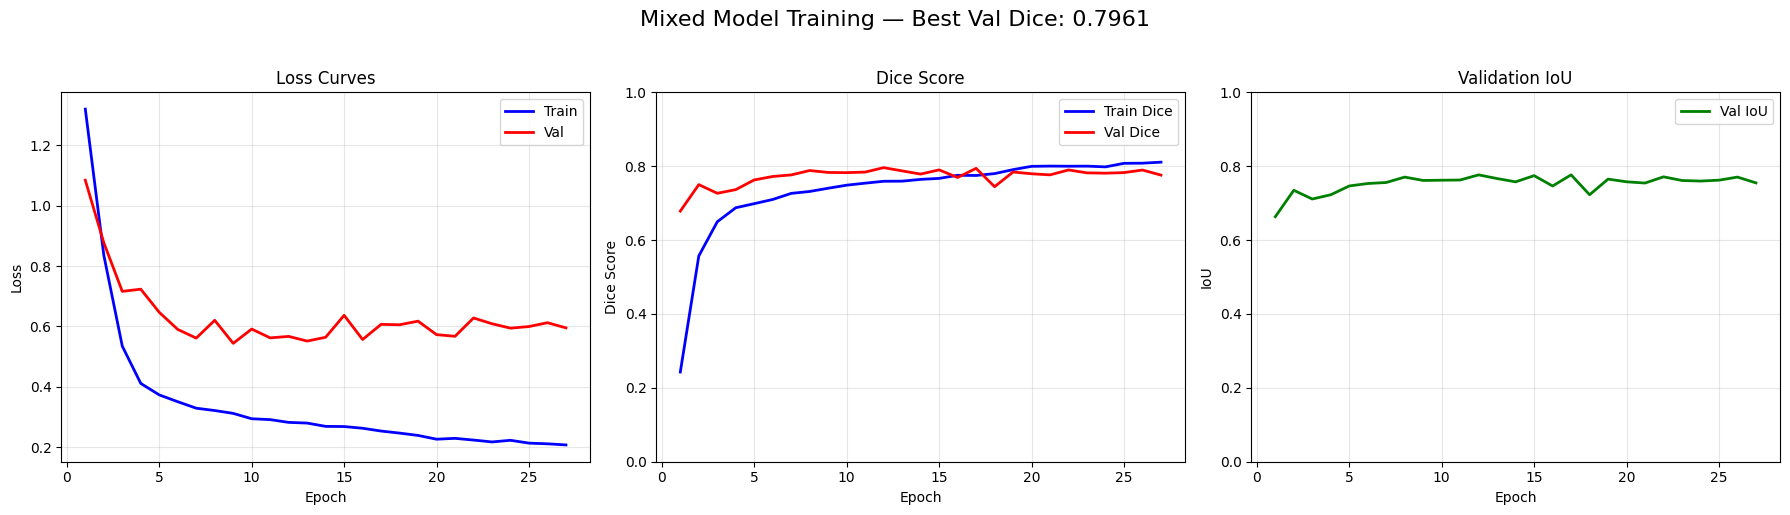

In [14]:
if history and len(history.get('train_loss', [])) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs_range = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss Curves')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)

    # Dice
    axes[1].plot(epochs_range, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
    axes[1].plot(epochs_range, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Dice Score'); axes[1].set_title('Dice Score')
    axes[1].legend(); axes[1].grid(True, alpha=0.3); axes[1].set_ylim(0, 1)

    # IoU
    axes[2].plot(epochs_range, history['val_iou'], 'g-', label='Val IoU', linewidth=2)
    axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('IoU'); axes[2].set_title('Validation IoU')
    axes[2].legend(); axes[2].grid(True, alpha=0.3); axes[2].set_ylim(0, 1)

    plt.suptitle(f'Mixed Model Training — Best Val Dice: {best_val_dice:.4f}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'mixed_training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No training history to plot.")

---
## Optimal Threshold Search

Don't just use 0.5 — find the threshold that maximizes **Dice** on the combined validation set (lung + brain).

In [15]:
# ⭐ KAGGLE TRICK #2: Optimal Threshold Search

# Memory cleanup
torch.cuda.empty_cache()
import gc; gc.collect()

def find_optimal_threshold_mixed(model, lung_loader, brain_loader, device,
                                  thresholds=np.arange(0.25, 0.60, 0.05)):
    """
    Search for optimal binary threshold on the combined lung + brain validation set.
    Uses canonical dice_per_sample.
    """
    model.eval()
    best_thr = 0.5
    best_dice = 0.0

    print(f"Threshold search: {[f'{t:.2f}' for t in thresholds]}")

    with torch.no_grad():
        for thr in thresholds:
            all_dice = []

            for loader in [lung_loader, brain_loader]:
                for images, masks in loader:
                    images, masks = images.to(device), masks.to(device)
                    with autocast(enabled=config.MIXED_PRECISION):
                        logits = model(images)
                    probs = torch.sigmoid(logits)
                    preds = (probs > thr).float()
                    dice = dice_per_sample(preds, masks)  # [B]
                    all_dice.append(dice)

            mean_dice = torch.cat(all_dice).mean().item()
            print(f"   thr={thr:.2f}  →  Dice={mean_dice:.4f}")

            if mean_dice > best_dice:
                best_dice = mean_dice
                best_thr = thr

    print(f"\n✅ Best threshold = {best_thr:.2f}  |  Dice = {best_dice:.4f}")
    return best_thr, best_dice


# Load best model and find optimal threshold
if best_model_path and os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model: {os.path.basename(best_model_path)}")

    optimal_threshold, optimal_dice = find_optimal_threshold_mixed(
        model, lung_val_loader, brain_val_loader, config.DEVICE
    )
else:
    optimal_threshold = 0.5
    optimal_dice = 0.0
    print("No trained model found — using default threshold=0.5")

Loaded best model: mixed_dice0.7961_iou0.7766.pth
Threshold search: ['0.25', '0.30', '0.35', '0.40', '0.45', '0.50', '0.55']
   thr=0.25  →  Dice=0.7930
   thr=0.25  →  Dice=0.7930
   thr=0.30  →  Dice=0.7921
   thr=0.30  →  Dice=0.7921
   thr=0.35  →  Dice=0.7923
   thr=0.35  →  Dice=0.7923
   thr=0.40  →  Dice=0.7949
   thr=0.40  →  Dice=0.7949
   thr=0.45  →  Dice=0.7951
   thr=0.45  →  Dice=0.7951
   thr=0.50  →  Dice=0.7961
   thr=0.50  →  Dice=0.7961
   thr=0.55  →  Dice=0.7954

✅ Best threshold = 0.50  |  Dice = 0.7961
   thr=0.55  →  Dice=0.7954

✅ Best threshold = 0.50  |  Dice = 0.7961


---
## Test-Time Augmentation (TTA)

Multi-scale + horizontal flip TTA. Both chest X-rays and axial brain FLAIR are compatible with horizontal flips.

In [16]:
# ⭐ KAGGLE TRICK #3: Test-Time Augmentation (TTA)
import torch.nn.functional as F


def pad_to_divisible_by_32(x):
    """Pad input tensor to make H and W divisible by 32 (encoder requirement)."""
    _, _, H, W = x.shape
    stride = 32
    pad_h = (stride - H % stride) % stride
    pad_w = (stride - W % stride) % stride
    if pad_h == 0 and pad_w == 0:
        return x, (0, 0, 0, 0)
    padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
    return F.pad(x, padding, mode='reflect'), padding


def crop_from_padding(x, padding):
    """Remove padding applied by pad_to_divisible_by_32."""
    if padding == (0, 0, 0, 0):
        return x
    pad_left, pad_right, pad_top, pad_bottom = padding
    _, _, H, W = x.shape
    return x[:, :, pad_top:H - pad_bottom, pad_left:W - pad_right]


def predict_with_tta(model, image, device, scales=(0.9, 1.0, 1.1), threshold=0.5):
    """
    Multi-scale + horizontal flip TTA.
    Works for both chest X-rays and axial brain FLAIR.

    Args:
        model: trained segmentation model
        image: single image tensor [C, H, W]
        device: torch device
        scales: tuple of scale factors
        threshold: binarization threshold

    Returns:
        prob_map (np.ndarray [H, W]), pred_binary (np.ndarray [H, W])
    """
    model.eval()
    image = image.unsqueeze(0).to(device)  # [1, C, H, W]
    _, _, H_orig, W_orig = image.shape

    logits_list = []

    with torch.no_grad():
        for s in scales:
            if s != 1.0:
                img_scaled = F.interpolate(image, scale_factor=s, mode="bilinear", align_corners=False)
            else:
                img_scaled = image

            img_padded, padding = pad_to_divisible_by_32(img_scaled)

            # Original orientation
            logits = model(img_padded)
            logits = crop_from_padding(logits, padding)

            # Horizontal flip
            img_hflip = torch.flip(img_padded, dims=[3])
            logits_hflip = model(img_hflip)
            logits_hflip = torch.flip(logits_hflip, dims=[3])
            logits_hflip = crop_from_padding(logits_hflip, padding)

            # Average flip logits
            logits_avg = (logits + logits_hflip) / 2.0

            # Resize back to original if needed
            if logits_avg.shape[-2:] != (H_orig, W_orig):
                logits_avg = F.interpolate(logits_avg, size=(H_orig, W_orig),
                                           mode="bilinear", align_corners=False)

            logits_list.append(logits_avg)

        final_logits = torch.mean(torch.stack(logits_list), dim=0)
        prob = torch.sigmoid(final_logits)
        pred_binary = (prob > threshold).float()

    return prob.squeeze().cpu().numpy(), pred_binary.squeeze().cpu().numpy()


print(" Multi-scale TTA defined (scales=0.9, 1.0, 1.1 + horizontal flip).")

 Multi-scale TTA defined (scales=0.9, 1.0, 1.1 + horizontal flip).


---
## Comprehensive Evaluation on Val / Test Sets

Evaluate the trained model with **all metrics** (Dice, IoU, F1, Precision, Recall, Accuracy) on:
- Lung validation & test
- Brain validation & test
- Combined (overall) validation & test

Both **without TTA** and **with TTA**.

In [17]:
# ── Comprehensive Evaluation Helper Functions ──

def comprehensive_evaluate_loader(model, data_loader, device, split_name="Evaluation",
                                   threshold=0.5):
    """
    Standard (no TTA) evaluation on a single loader.
    Returns dict of averaged metrics.
    """
    model.eval()
    metrics = {k: 0.0 for k in ['loss', 'dice', 'iou', 'f1', 'precision', 'recall', 'accuracy']}
    total = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc=f"Eval {split_name}", leave=False):
            images, masks = images.to(device), masks.to(device)
            bs = images.size(0)
            total += bs

            with autocast(enabled=config.MIXED_PRECISION):
                logits = model(images)
                loss = criterion(logits, masks)

            metrics['loss'] += loss.item() * bs

            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            dice_batch = dice_per_sample(preds, masks)
            metrics['dice'] += dice_batch.sum().item()

            metrics['iou']       += iou_score(logits, masks, threshold=threshold).item() * bs
            metrics['f1']        += f1_score(logits, masks, threshold=threshold).item() * bs
            metrics['precision'] += precision_score(logits, masks, threshold=threshold).item() * bs
            metrics['recall']    += recall_score(logits, masks, threshold=threshold).item() * bs
            metrics['accuracy']  += accuracy_score(logits, masks, threshold=threshold).item() * bs

    if total > 0:
        for k in metrics:
            metrics[k] /= total
    return metrics


def comprehensive_evaluate_loader_tta(model, data_loader, device, split_name="Evaluation (TTA)",
                                       threshold=0.5):
    """
    TTA-based evaluation on a single loader.
    Loss is computed from raw logits (no TTA) for comparability.
    """
    model.eval()
    metrics = {k: 0.0 for k in ['loss', 'dice', 'iou', 'f1', 'precision', 'recall', 'accuracy']}
    total = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc=f"Eval {split_name} (TTA)", leave=False):
            images, masks = images.to(device), masks.to(device)
            bs = images.size(0)
            total += bs

            # Loss from raw logits
            with autocast(enabled=config.MIXED_PRECISION):
                logits = model(images)
                loss = criterion(logits, masks)
            metrics['loss'] += loss.item() * bs

            # TTA predictions per image
            preds_list = []
            for b in range(bs):
                _, pred_bin_np = predict_with_tta(model, images[b].cpu(), device, threshold=threshold)
                pred_t = torch.from_numpy(pred_bin_np).float().to(device)
                if pred_t.ndim == 2:
                    pred_t = pred_t.unsqueeze(0)
                preds_list.append(pred_t)
            preds_binary = torch.stack(preds_list, dim=0)  # [B,1,H,W]

            # Dice
            dice_batch = dice_per_sample(preds_binary, masks)
            metrics['dice'] += dice_batch.sum().item()

            # Other metrics from binary preds
            tp = (preds_binary * masks).sum(dim=(1, 2, 3))
            fp = (preds_binary * (1 - masks)).sum(dim=(1, 2, 3))
            fn = ((1 - preds_binary) * masks).sum(dim=(1, 2, 3))
            intersection = tp
            union = preds_binary.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection

            iou_b = (intersection + 1e-6) / (union + 1e-6)
            prec_b = (tp + 1e-6) / (tp + fp + 1e-6)
            rec_b  = (tp + 1e-6) / (tp + fn + 1e-6)
            f1_b   = 2 * (prec_b * rec_b) / (prec_b + rec_b + 1e-6)
            acc_b  = (preds_binary == masks).float().view(bs, -1).mean(dim=1)

            metrics['iou']       += iou_b.sum().item()
            metrics['f1']        += f1_b.sum().item()
            metrics['precision'] += prec_b.sum().item()
            metrics['recall']    += rec_b.sum().item()
            metrics['accuracy']  += acc_b.sum().item()

    if total > 0:
        for k in metrics:
            metrics[k] /= total
    return metrics


def print_metrics_table(results_dict: Dict[str, Dict[str, float]]):
    """Pretty-print a table of metrics for multiple splits/conditions."""
    header = f"{'Split':<30} {'Loss':>8} {'Dice':>8} {'IoU':>8} {'F1':>8} {'Prec':>8} {'Rec':>8} {'Acc':>8}"
    print(header)
    print("-" * len(header))
    for name, m in results_dict.items():
        print(f"{name:<30} {m['loss']:8.4f} {m['dice']:8.4f} {m['iou']:8.4f} "
              f"{m['f1']:8.4f} {m['precision']:8.4f} {m['recall']:8.4f} {m['accuracy']:8.4f}")
    print()

print(" Comprehensive evaluation helpers defined.")

 Comprehensive evaluation helpers defined.


In [18]:
# ── Run Comprehensive Evaluation on Val + Test (per-organ + combined) ──

eval_thr = optimal_threshold if 'optimal_threshold' in dir() else 0.5
print(f"Using threshold = {eval_thr:.2f} for evaluation\n")

# Ensure best model is loaded
if best_model_path and os.path.exists(best_model_path):
    ckpt = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    print(f"Loaded best model: {os.path.basename(best_model_path)}\n")

results = {}

# ── VALIDATION (no TTA) ──
print("=" * 70)
print("VALIDATION SET — no TTA")
print("=" * 70)

results["Val Lung  (no TTA)"]  = comprehensive_evaluate_loader(
    model, lung_val_loader, config.DEVICE, "Val Lung", threshold=eval_thr)
results["Val Brain (no TTA)"]  = comprehensive_evaluate_loader(
    model, brain_val_loader, config.DEVICE, "Val Brain", threshold=eval_thr)

# Combined val (weighted average by sample count)
n_lung_val  = len(lung_val_ds)
n_brain_val = len(brain_val_ds)
n_total_val = n_lung_val + n_brain_val
combined_val = {}
for k in results["Val Lung  (no TTA)"]:
    combined_val[k] = (results["Val Lung  (no TTA)"][k] * n_lung_val +
                       results["Val Brain (no TTA)"][k] * n_brain_val) / max(n_total_val, 1)
results["Val Combined (no TTA)"] = combined_val

print_metrics_table({k: v for k, v in results.items() if "Val" in k and "TTA" not in k or "no TTA" in k})

# ── VALIDATION (with TTA) ──
print("=" * 70)
print("VALIDATION SET — with TTA")
print("=" * 70)

results["Val Lung  (TTA)"]  = comprehensive_evaluate_loader_tta(
    model, lung_val_loader, config.DEVICE, "Val Lung TTA", threshold=eval_thr)
results["Val Brain (TTA)"]  = comprehensive_evaluate_loader_tta(
    model, brain_val_loader, config.DEVICE, "Val Brain TTA", threshold=eval_thr)

combined_val_tta = {}
for k in results["Val Lung  (TTA)"]:
    combined_val_tta[k] = (results["Val Lung  (TTA)"][k] * n_lung_val +
                           results["Val Brain (TTA)"][k] * n_brain_val) / max(n_total_val, 1)
results["Val Combined (TTA)"] = combined_val_tta

print_metrics_table({k: v for k, v in results.items() if "Val" in k and "TTA" in k and "no" not in k})

# ── TEST (no TTA) ──
print("=" * 70)
print("TEST SET — no TTA")
print("=" * 70)

results["Test Lung  (no TTA)"]  = comprehensive_evaluate_loader(
    model, lung_test_loader, config.DEVICE, "Test Lung", threshold=eval_thr)
results["Test Brain (no TTA)"]  = comprehensive_evaluate_loader(
    model, brain_test_loader, config.DEVICE, "Test Brain", threshold=eval_thr)

n_lung_test  = len(lung_test_ds)
n_brain_test = len(brain_test_ds)
n_total_test = n_lung_test + n_brain_test
combined_test = {}
for k in results["Test Lung  (no TTA)"]:
    combined_test[k] = (results["Test Lung  (no TTA)"][k] * n_lung_test +
                        results["Test Brain (no TTA)"][k] * n_brain_test) / max(n_total_test, 1)
results["Test Combined (no TTA)"] = combined_test

print_metrics_table({k: v for k, v in results.items() if "Test" in k and "no TTA" in k})

# ── TEST (with TTA) ──
print("=" * 70)
print("TEST SET — with TTA")
print("=" * 70)

results["Test Lung  (TTA)"]  = comprehensive_evaluate_loader_tta(
    model, lung_test_loader, config.DEVICE, "Test Lung TTA", threshold=eval_thr)
results["Test Brain (TTA)"]  = comprehensive_evaluate_loader_tta(
    model, brain_test_loader, config.DEVICE, "Test Brain TTA", threshold=eval_thr)

combined_test_tta = {}
for k in results["Test Lung  (TTA)"]:
    combined_test_tta[k] = (results["Test Lung  (TTA)"][k] * n_lung_test +
                            results["Test Brain (TTA)"][k] * n_brain_test) / max(n_total_test, 1)
results["Test Combined (TTA)"] = combined_test_tta

print_metrics_table({k: v for k, v in results.items() if "Test" in k and "TTA" in k and "no" not in k})

# ── FULL SUMMARY TABLE ──
print("\n" + "=" * 70)
print("FULL SUMMARY — ALL SPLITS / CONDITIONS")
print("=" * 70)
print_metrics_table(results)

Using threshold = 0.50 for evaluation

Loaded best model: mixed_dice0.7961_iou0.7766.pth

VALIDATION SET — no TTA


Eval Val Lung:   0%|          | 0/40 [00:00<?, ?it/s]

Eval Val Brain:   0%|          | 0/13 [00:00<?, ?it/s]

Split                              Loss     Dice      IoU       F1     Prec      Rec      Acc
---------------------------------------------------------------------------------------------
Val Lung  (no TTA)               0.6574   0.7809   0.7658   0.7809   0.9266   0.8099   0.9968
Val Brain (no TTA)               0.2897   0.8429   0.8096   0.8429   0.9675   0.8349   0.9956
Val Combined (no TTA)            0.5670   0.7961   0.7766   0.7961   0.9366   0.8160   0.9965

VALIDATION SET — with TTA


Eval Val Lung TTA (TTA):   0%|          | 0/40 [00:00<?, ?it/s]

Eval Val Brain TTA (TTA):   0%|          | 0/13 [00:00<?, ?it/s]

Split                              Loss     Dice      IoU       F1     Prec      Rec      Acc
---------------------------------------------------------------------------------------------
Val Lung  (TTA)                  0.6574   0.7869   0.7731   0.7869   0.9455   0.8030   0.9968
Val Brain (TTA)                  0.2897   0.8435   0.8107   0.8435   0.9837   0.8223   0.9953
Val Combined (TTA)               0.5670   0.8008   0.7824   0.8008   0.9549   0.8078   0.9964

TEST SET — no TTA


Eval Test Lung:   0%|          | 0/40 [00:00<?, ?it/s]

Eval Test Brain:   0%|          | 0/13 [00:00<?, ?it/s]

Split                              Loss     Dice      IoU       F1     Prec      Rec      Acc
---------------------------------------------------------------------------------------------
Test Lung  (no TTA)              0.6756   0.7852   0.7710   0.7852   0.9182   0.8249   0.9971
Test Brain (no TTA)              0.3126   0.8287   0.7994   0.8287   0.9761   0.8176   0.9958
Test Combined (no TTA)           0.5863   0.7959   0.7780   0.7959   0.9325   0.8231   0.9968

TEST SET — with TTA


Eval Test Lung TTA (TTA):   0%|          | 0/40 [00:00<?, ?it/s]

Eval Test Brain TTA (TTA):   0%|          | 0/13 [00:00<?, ?it/s]

Split                              Loss     Dice      IoU       F1     Prec      Rec      Acc
---------------------------------------------------------------------------------------------
Test Lung  (TTA)                 0.6756   0.7951   0.7834   0.7951   0.9465   0.8171   0.9971
Test Brain (TTA)                 0.3126   0.8289   0.8002   0.8289   0.9868   0.8092   0.9955
Test Combined (TTA)              0.5863   0.8034   0.7875   0.8034   0.9564   0.8151   0.9967


FULL SUMMARY — ALL SPLITS / CONDITIONS
Split                              Loss     Dice      IoU       F1     Prec      Rec      Acc
---------------------------------------------------------------------------------------------
Val Lung  (no TTA)               0.6574   0.7809   0.7658   0.7809   0.9266   0.8099   0.9968
Val Brain (no TTA)               0.2897   0.8429   0.8096   0.8429   0.9675   0.8349   0.9956
Val Combined (no TTA)            0.5670   0.7961   0.7766   0.7961   0.9366   0.8160   0.9965
Val Lung  (TTA)    

---
## Visualize Predictions with TTA

Show model predictions on sample lung and brain images using optimal threshold + TTA.

Visualizing predictions with TTA, threshold=0.50



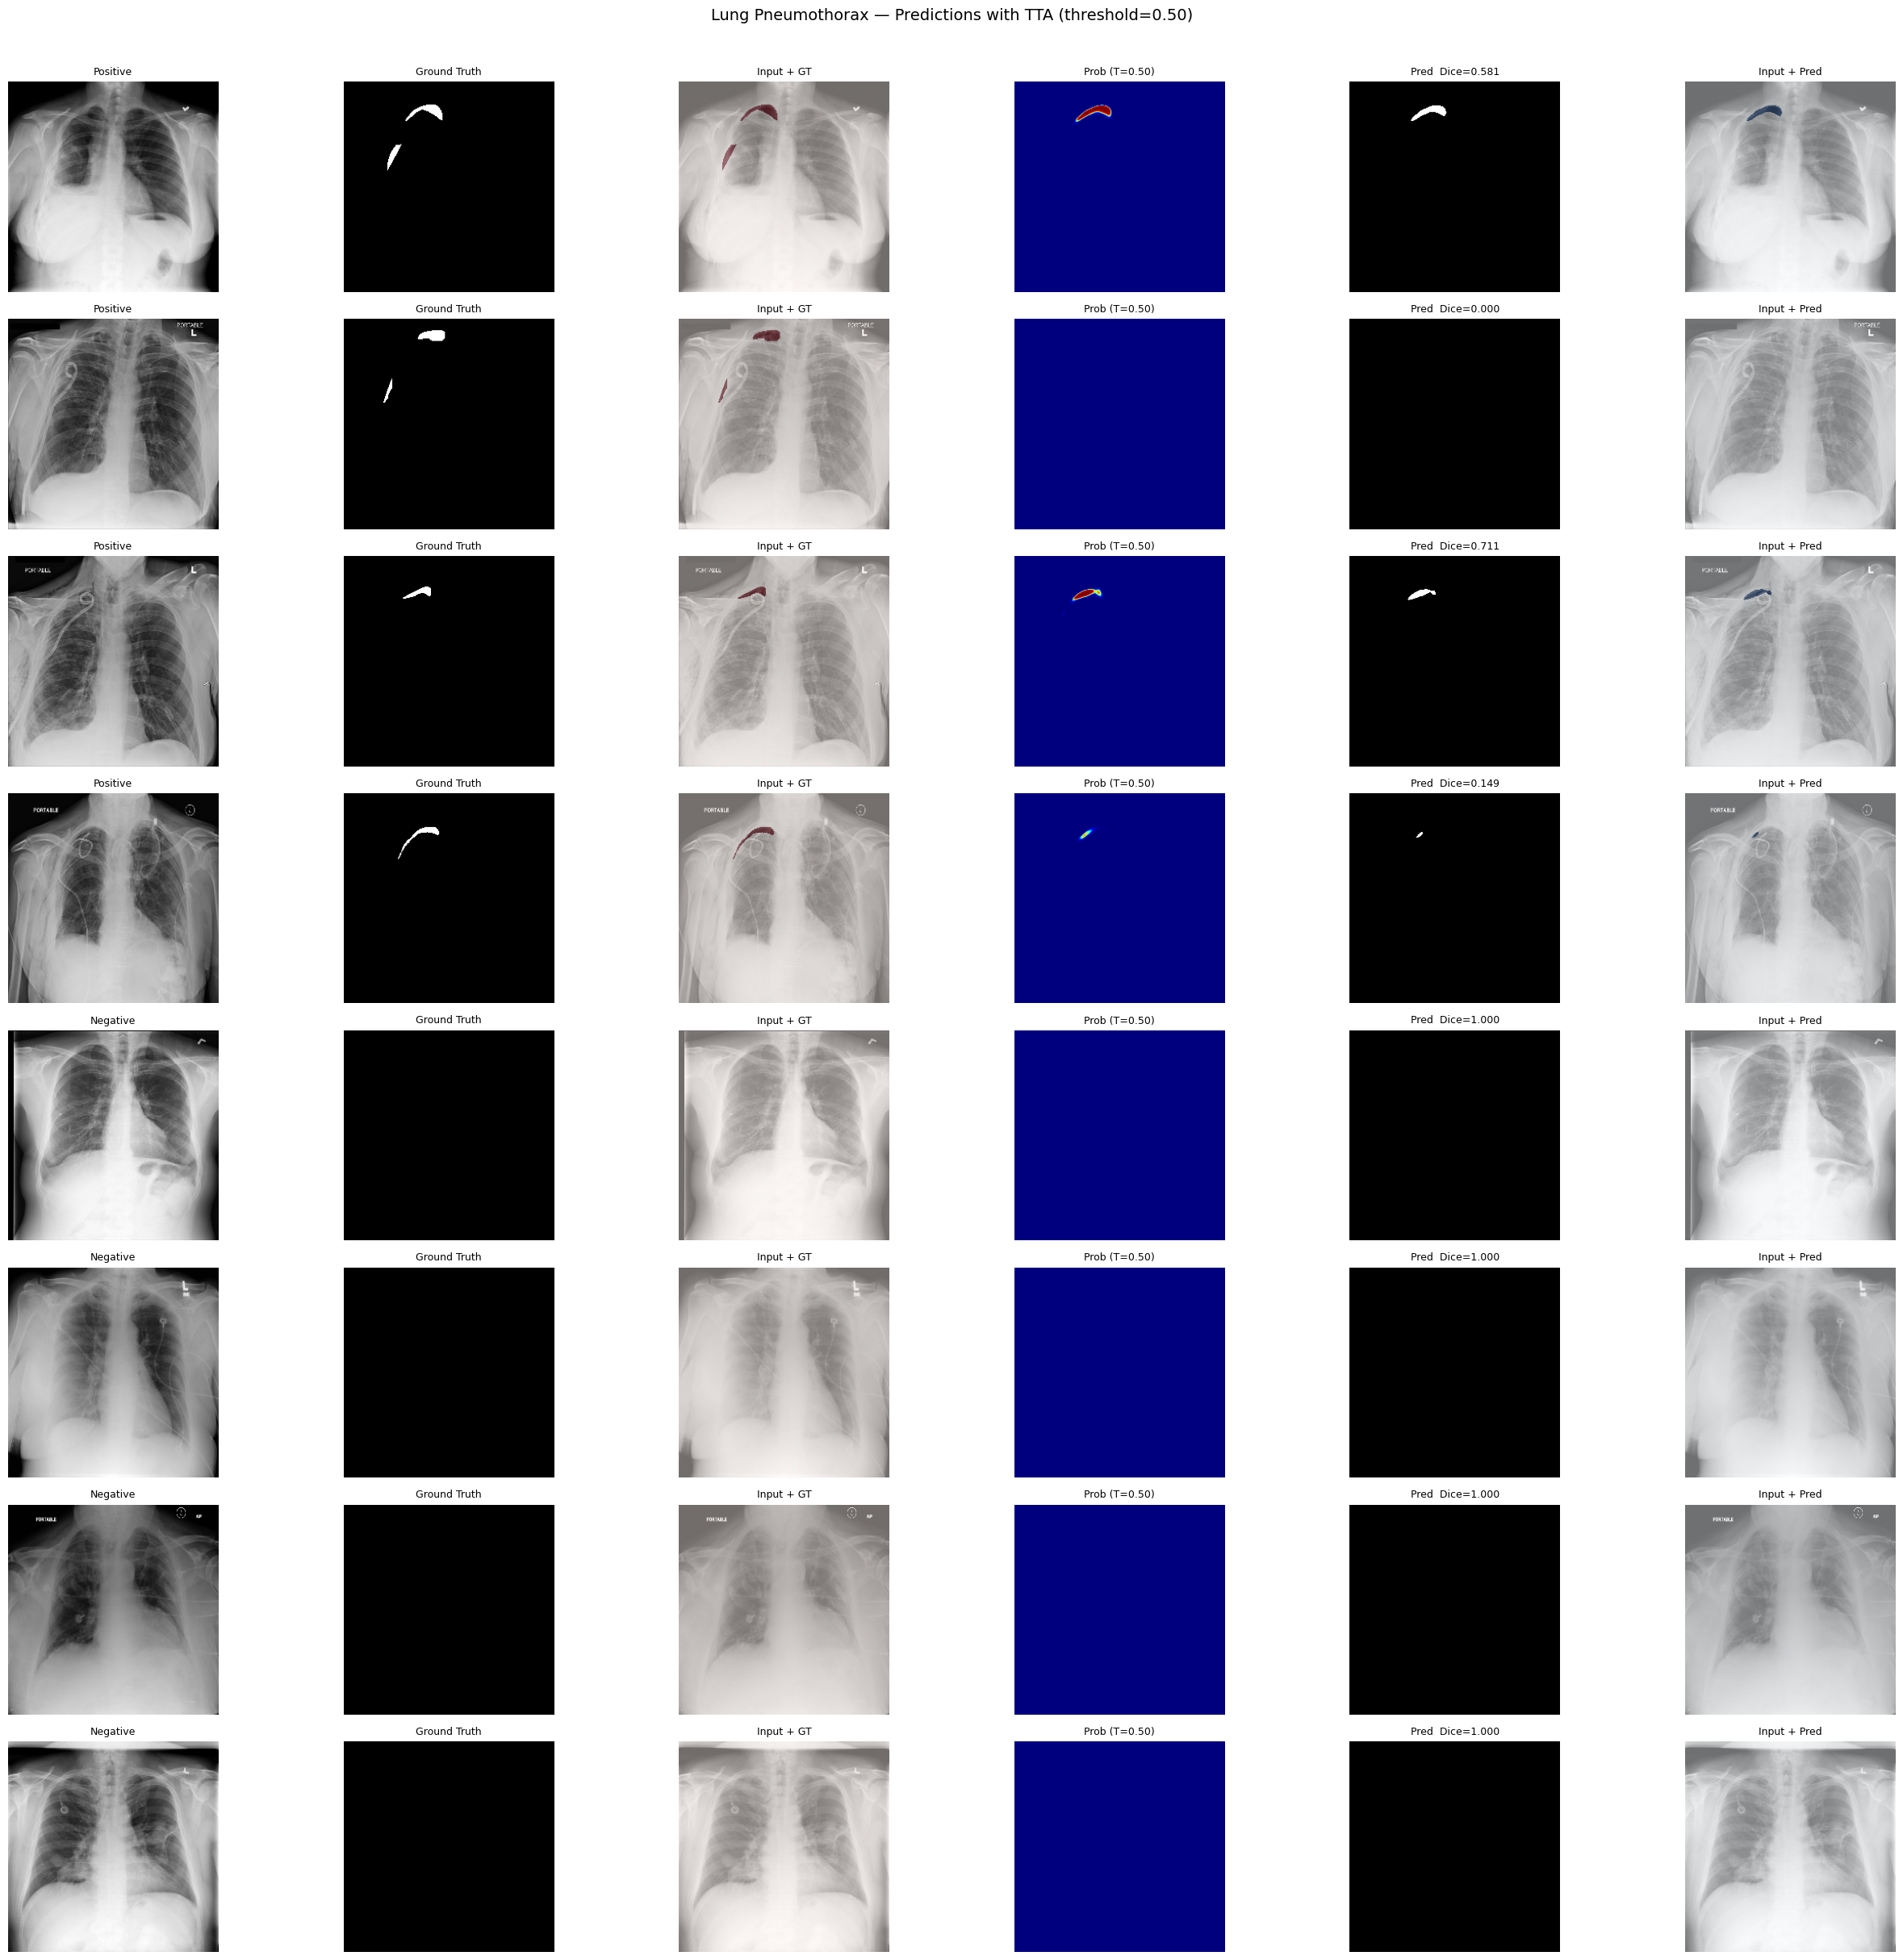

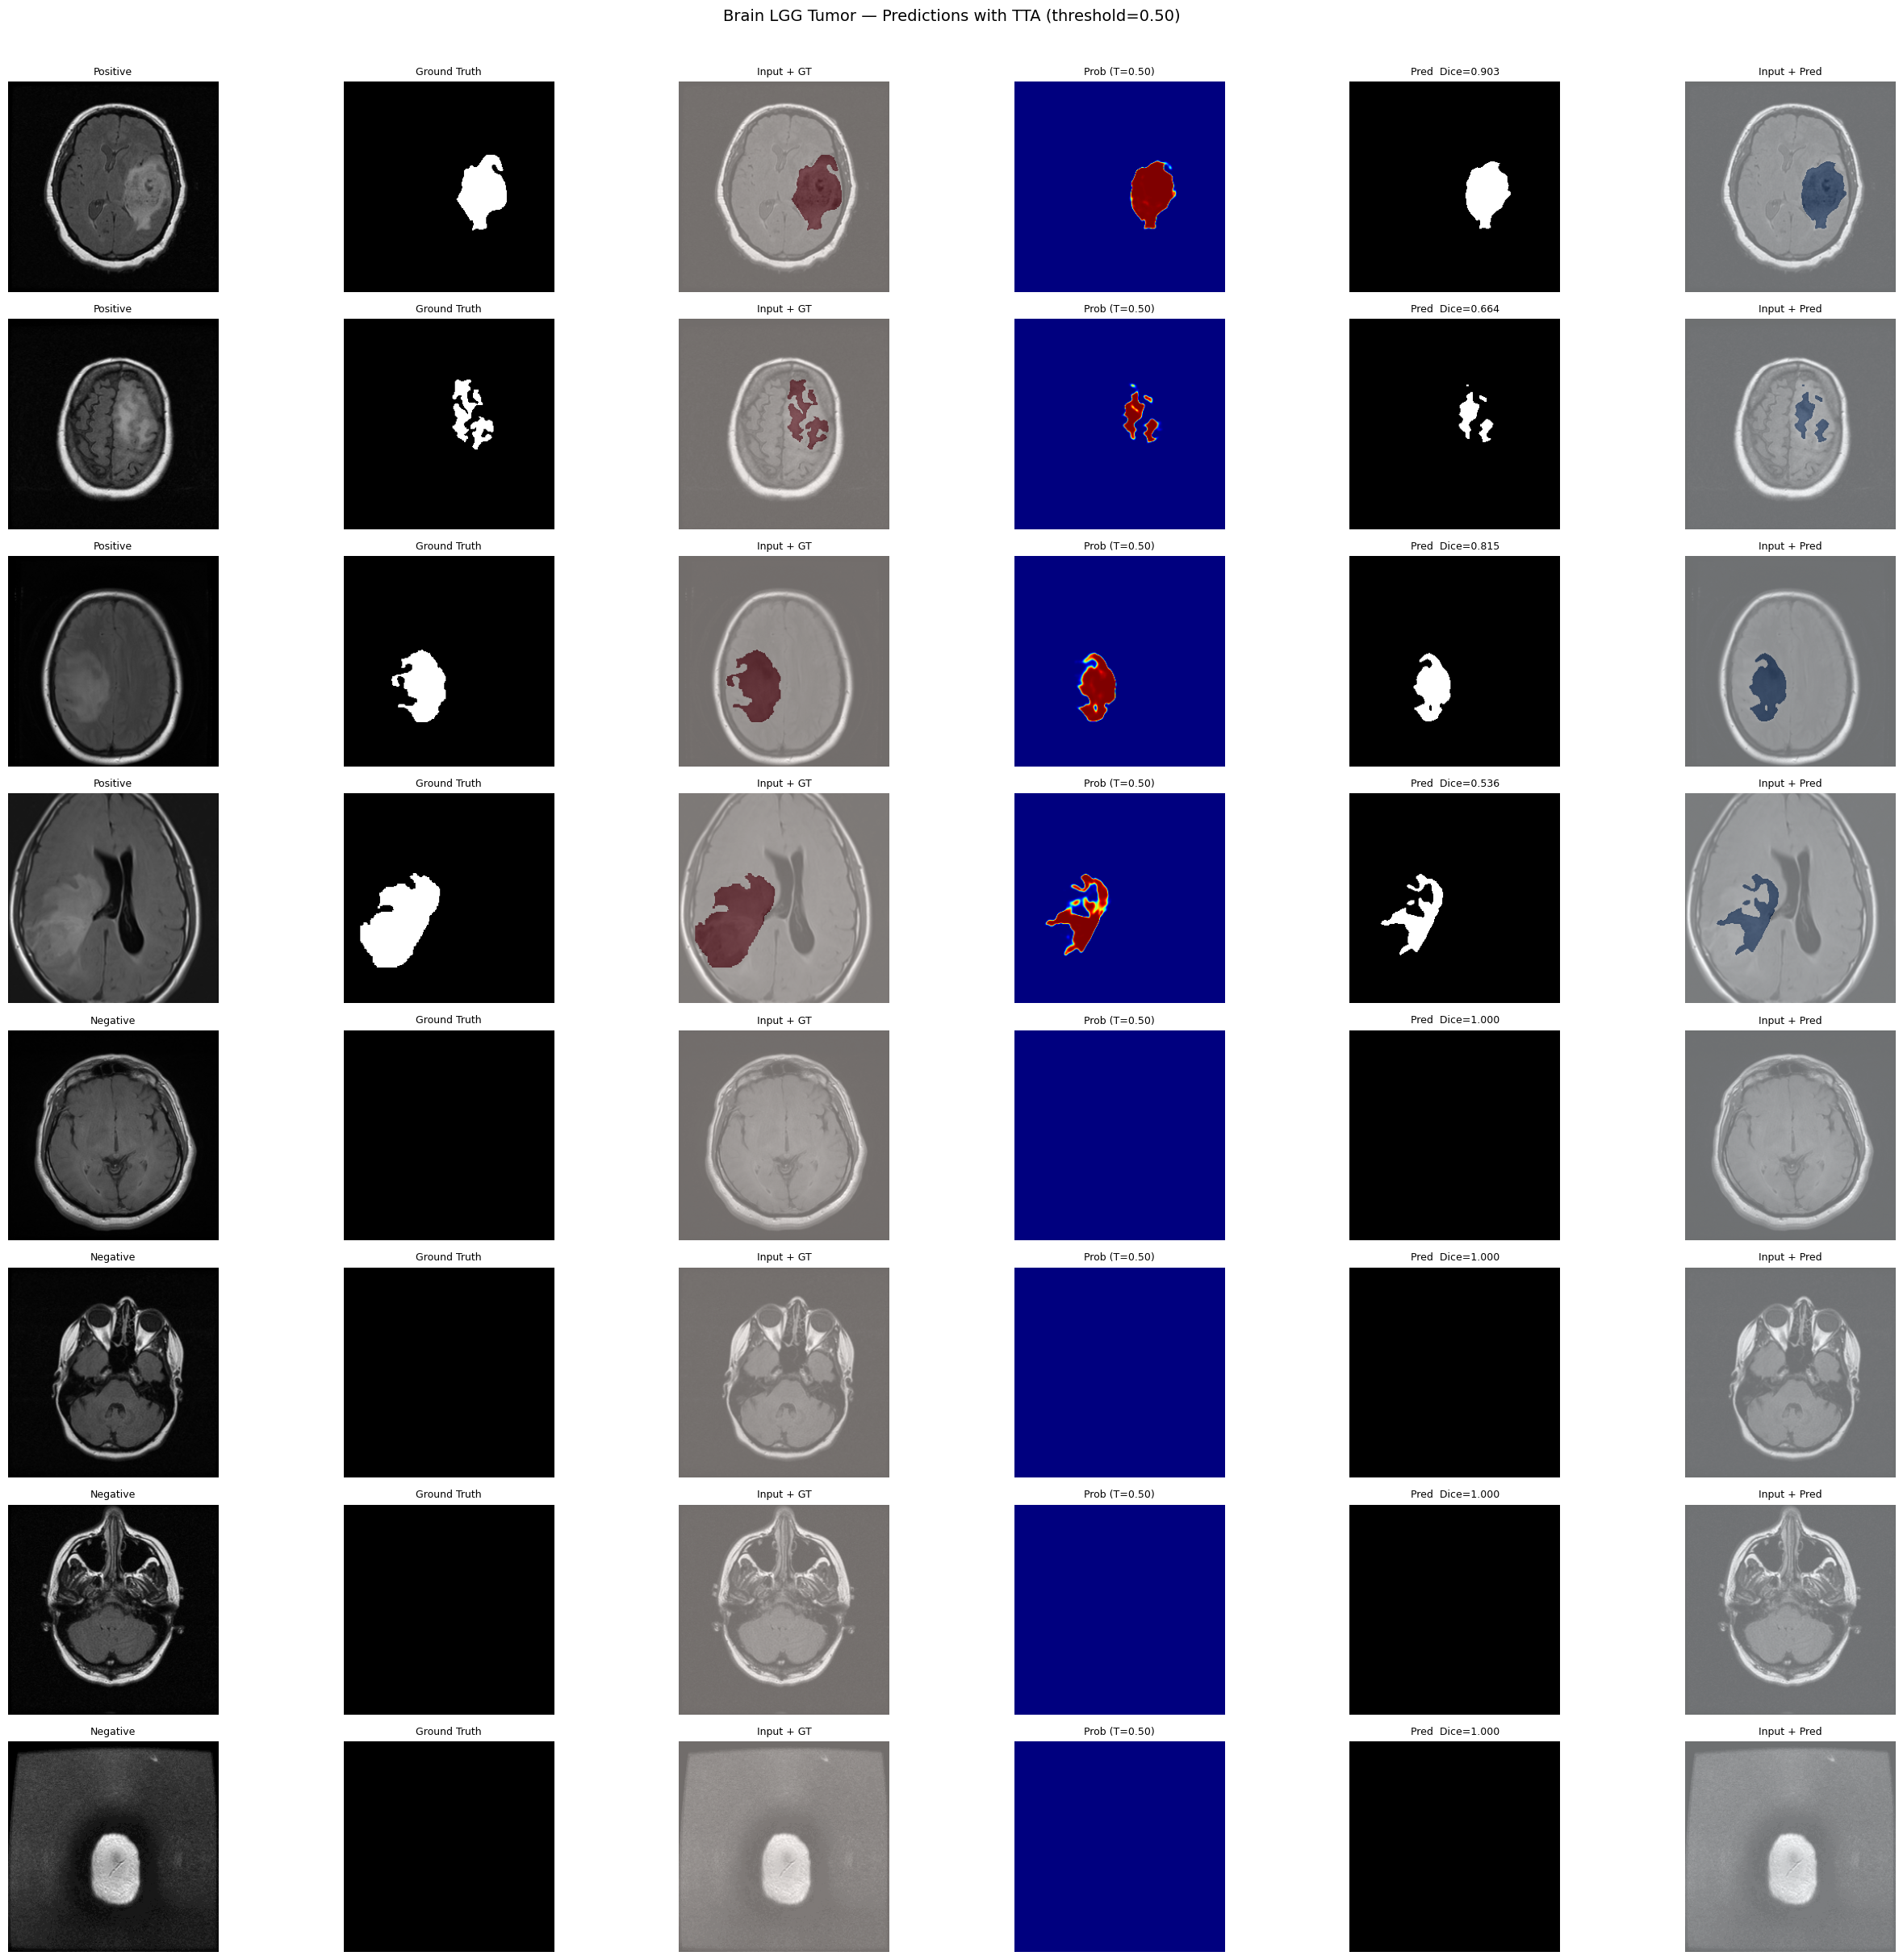


 Prediction visualizations saved to: mixed_output


In [19]:
# ── Visualize Predictions: Lung + Brain with TTA ──

def visualize_predictions_mixed(model, dataset, pairs, has_annotation, domain_name,
                                 device, threshold, n_per_class=4):
    """
    Visualize predictions for a single domain.
    Shows n positive + n negative samples with 6 columns:
    Input | GT Mask | Input+GT | Prob Map | Pred Mask | Input+Pred
    """
    pos_idx = np.where(has_annotation == 1)[0]
    neg_idx = np.where(has_annotation == 0)[0]

    np.random.seed(config.SEED)
    pos_pick = np.random.choice(pos_idx, min(n_per_class, len(pos_idx)), replace=False) if len(pos_idx) > 0 else np.array([], dtype=int)
    neg_pick = np.random.choice(neg_idx, min(n_per_class, len(neg_idx)), replace=False) if len(neg_idx) > 0 else np.array([], dtype=int)

    show_idx = list(pos_pick) + list(neg_pick)
    show_lbl = ["Positive"] * len(pos_pick) + ["Negative"] * len(neg_pick)

    if len(show_idx) == 0:
        print(f"No samples to visualize for {domain_name}")
        return

    fig, axes = plt.subplots(len(show_idx), 6, figsize=(26, len(show_idx) * 3))
    if len(show_idx) == 1:
        axes = axes.reshape(1, 6)

    model.eval()
    for row, (idx, lbl) in enumerate(zip(show_idx, show_lbl)):
        image, mask = dataset[idx]

        # TTA prediction
        prob_map, pred_binary = predict_with_tta(model, image, device, threshold=threshold)

        # De-normalize for display (z-score → approximate [0,1])
        img_np = image.permute(1, 2, 0).numpy()
        img_display = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
        mask_np = mask.squeeze().numpy()

        # Per-sample Dice
        if mask_np.sum() == 0 and pred_binary.sum() == 0:
            sample_dice = 1.0
        else:
            inter = (pred_binary * mask_np).sum()
            sample_dice = 2 * inter / (pred_binary.sum() + mask_np.sum() + 1e-6)

        # Col 0: Input
        axes[row, 0].imshow(img_display, cmap='gray')
        axes[row, 0].set_title(f'{lbl}', fontsize=9)
        axes[row, 0].axis('off')

        # Col 1: GT Mask
        axes[row, 1].imshow(mask_np, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=9)
        axes[row, 1].axis('off')

        # Col 2: Input + GT overlay
        axes[row, 2].imshow(img_display, cmap='gray')
        axes[row, 2].imshow(mask_np, alpha=0.45, cmap='Reds')
        axes[row, 2].set_title('Input + GT', fontsize=9)
        axes[row, 2].axis('off')

        # Col 3: Probability map
        axes[row, 3].imshow(prob_map, cmap='jet', vmin=0, vmax=1)
        axes[row, 3].set_title(f'Prob (T={threshold:.2f})', fontsize=9)
        axes[row, 3].axis('off')

        # Col 4: Predicted mask
        axes[row, 4].imshow(pred_binary, cmap='gray')
        axes[row, 4].set_title(f'Pred  Dice={sample_dice:.3f}', fontsize=9)
        axes[row, 4].axis('off')

        # Col 5: Input + Pred overlay
        axes[row, 5].imshow(img_display, cmap='gray')
        axes[row, 5].imshow(pred_binary, alpha=0.45, cmap='Blues')
        axes[row, 5].set_title('Input + Pred', fontsize=9)
        axes[row, 5].axis('off')

    plt.suptitle(f'{domain_name} — Predictions with TTA (threshold={threshold:.2f})',
                 fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, f'mixed_preds_{domain_name.lower().replace(" ", "_")}.png'),
                dpi=150, bbox_inches='tight')
    plt.show()


# Ensure best model is loaded
if best_model_path and os.path.exists(best_model_path):
    ckpt = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()

vis_thr = optimal_threshold if 'optimal_threshold' in dir() else 0.5

print(f"Visualizing predictions with TTA, threshold={vis_thr:.2f}\n")

# Lung predictions (val set)
visualize_predictions_mixed(
    model, lung_val_ds, lung_val, lung_val_has_annotation,
    "Lung Pneumothorax", config.DEVICE, vis_thr, n_per_class=4
)

# Brain predictions (val set)
visualize_predictions_mixed(
    model, brain_val_ds, brain_val, brain_val_has_annotation,
    "Brain LGG Tumor", config.DEVICE, vis_thr, n_per_class=4
)

print("\n Prediction visualizations saved to:", config.OUTPUT_DIR)